## Import Libraries
This cell imports the necessary libraries such as numpy, matplotlib, librosa, and sklearn. These libraries are essential for signal processing and machine learning tasks.

In [207]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import scipy.signal as signal
import numpy as np
from sklearn.cluster import KMeans
import librosa
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import clear_output

## Solvers 
This class implements different optimization methods (proximal, IRLS, and CVXPY) to estimate source signals from mixtures using methods like gradient descent and convex optimization.
The `Solvers` class provides different optimization methods for separating sources from mixtures. It supports three optimization techniques: **proximal**, **IRLS** (Iteratively Reweighted Least Squares), and **CVXPY**. The class implements the following key methods:

1. **Initialization (`__init__`)**:
   - The constructor initializes the solver with attenuation, delays, mixtures, and additional hyperparameters for the selected optimization method.

2. **IRLS Optimization**:
   - The `IRLS` method estimates the sources using an iterative process, where each iteration involves solving a weighted least squares problem and updating the weights.

3. **Proximal Optimization**:
   - The `solve_pq_optimization_proximal` method solves the Pq optimization problem using the Proximal Gradient Descent method, which includes a gradient descent step and a proximal operator.

4. **CVXPY Optimization**:
   - The `solve_pq_optimization` method uses the CVXPY library to solve the Pq optimization problem with a convex optimization approach.

5. **Auxiliary Functions**:
   - **`A_l`**: Computes the mixing matrix for a given time-frequency point.
   - **`__proximal_operator`**: Implements the proximal operator for the q-norm.
   - **`__gradient_step`**: Performs one step of gradient descent.
   - **`get_method`**: Returns the appropriate optimization method based on the chosen method name.

6. **Source Estimation**:
   - The `solve` method applies the selected optimization method to all time-frequency points in the mixtures, estimating the sources for each point.


In [208]:
import cvxpy as cp
import numpy as np

class Solvers:
    def __init__(self, Attentuation, delays, mixtures_stft, method_name, w_0=1, **args):
        """
        Initialize the solver with attenuation, delays, mixtures, and additional hyperparameters.
        
        Args:
        - Attentuation: Attenuation matrix (m x n).
        - delays: Delay matrix (m x n).
        - mixtures_stft: Short-time Fourier transform of mixtures.
        - method_name: Name of the method to use for optimization ('gard proximal', 'IRLS', or 'CVXPY').
        - w_0: A parameter for the frequency-related computation (default 1).
        - **args: Additional hyperparameters to be passed to the method.
        """
        self.Attentuation = Attentuation
        self.delays = delays
        self.mixtures_stft = mixtures_stft
        self.n_mix = Attentuation.shape[0]
        self.n_sources = Attentuation.shape[1]
        self.w_0 = w_0
        self.method_name = method_name
        self.args = args  # Store additional hyperparameters as a dictionary
        
    def get_method(self): 
        
        """
        Select the optimization method based on the provided method name.
        """
        if self.method_name == 'proximal': 
            return self.solve_pq_optimization_proximal
        elif self.method_name == 'IRLS': 
            return self.IRLS
        elif self.method_name == 'CVXPY':
            return self.solve_pq_optimization
        else:
            raise ValueError(f"Unknown method: {self.method_name}")
    
    def IRLS(self, A, b, **kwargs):
        """
        IRLS optimization function.
        
        Args:
        - A: Mixing matrix.
        - b: Mixture vector.
        - **kwargs: Additional hyperparameters for IRLS.
        
        Returns:
        - Estimated sources vector.
        """
        K = kwargs.get('K', 3)
        q = kwargs.get('q', 0.5)
        
        W = np.identity(A.shape[1])
        x_estim = np.ones(A.shape[1])
        
        for i in range(K):
            x_estim = W @ W @ A.T @ np.linalg.inv(A @ W @ W @ A.T) @ b
            z = np.abs(x_estim) ** (1 - q / 2)
            W = np.diag(z)
            
        return x_estim
    
    def A_l(self, l):
        """
        Compute the matrix A for a given time-frequency point [k, l].
        
        Args:
        - l: The time-frequency point index.
        
        Returns:
        - A_l: The computed mixing matrix at time-frequency point l.
        """
        A_l = np.zeros((self.n_mix, self.n_sources), dtype=complex)
        for i in range(self.n_mix):
            for j in range(self.n_sources):
                A_l[i, j] = self.Attentuation[i, j] * np.exp(-1j * 2 * np.pi * l * self.delays[i, j] * self.w_0)
        return A_l

    def __proximal_operator(self, x, **kwargs):
        """
        Proximal operator for the q-norm (non-convex for q < 1).
        
        Args:
        - x: The input vector (complex-valued).
        - **kwargs: Additional parameters like `q` and `lambda_param`.
        
        Returns:
        - The result of applying the proximal operator.
        """
        q = kwargs.get('q', 0.5)
        lambda_param = kwargs.get('lambda_param', 0.1)
        
        magnitude = np.abs(x)
        return np.sign(x) * np.maximum(magnitude - lambda_param, 0) ** q

    def __gradient_step(self, A, x, s_e, **kwargs):
        """
        Perform one step of the gradient descent.
        
        Args:
        - A: Mixing matrix.
        - x: Mixture vector.
        - s_e: Current source estimate.
        - **kwargs: Additional hyperparameters like learning_rate.
        
        Returns:
        - Updated s_e after the gradient descent step.
        """
        learning_rate = kwargs.get('learning_rate', 0.01)
        grad = A.T @ (A @ s_e - x)  # Compute the gradient of the loss
        return s_e - learning_rate * grad

    def solve_pq_optimization_proximal(self, A, x, **kwargs):
        """
        Solve the Pq optimization problem for a given time-frequency point using Proximal Gradient Descent.
        
        Args:
        - A: Mixing matrix at time-frequency point [k, l].
        - x: Mixture vector at time-frequency point [k, l].
        - **kwargs: Additional hyperparameters like `q`, `lambda_param`, `max_iter`, `learning_rate`.
        
        Returns:
        - s_e: Sparse source estimate at time-frequency point [k, l].
        """
        max_iter = kwargs.get('max_iter', 100)
        q = kwargs.get('q', 0.5)
        lambda_param = kwargs.get('lambda_param', 0.1)
        learning_rate = kwargs.get('learning_rate', 0.01)
        
        _, n = A.shape
        s_e = np.zeros(n, dtype=complex)
        
        for _ in range(max_iter):
            s_e = self.__gradient_step(A, x, s_e, learning_rate=learning_rate)
            s_e = self.__proximal_operator(s_e, q=q, lambda_param=lambda_param)
        
        return s_e

    def solve_pq_optimization(self, A, x, **kwargs):
        """
        Solve the Pq optimization problem for a given time-frequency point using CVXPY.
        
        Args:
        - A: Estimated mixing matrix at time-frequency point [k, l] (m x n).
        - x: Mixture vector at time-frequency point [k, l] (m x 1).
        - **kwargs: Hyperparameters for CVXPY optimization, like `q`, `epsilon`.
        
        Returns:
        - s_e: Sparse source estimate at time-frequency point [k, l].
        """
        q = kwargs.get('q', 0.5)
        epsilon = kwargs.get('epsilon', 1e-8)
        
        m, n = A.shape
        s_e = cp.Variable(n, complex=True)
        
        # Objective: Minimize the q-norm of s_e (sparsity measure)
        objective = cp.Minimize(cp.norm(cp.abs(s_e), q) + epsilon * cp.norm(s_e))
        
        # Constraint: A * s_e = x
        constraint = [A @ s_e == x]
        
        problem = cp.Problem(objective, constraint)
        problem.solve()
        
        return s_e.value

    def solve(self, **kwargs):
        """
        Apply the selected optimization method to all time-frequency points in the mixtures.
        
        Args:
        - **kwargs: Hyperparameters for the chosen method (q, lambda_param, max_iter, etc.)
        
        Returns:
        - estimated_sources: The estimated sources in the time-frequency domain.
        """
        estimated_sources = np.zeros((self.n_sources, self.mixtures_stft.shape[1], self.mixtures_stft.shape[2]), dtype=complex)
        
        for k in range(self.mixtures_stft.shape[2]):
            A_l = self.A_l(k)
            for l in range(self.mixtures_stft.shape[1]):
                x = np.array([self.mixtures_stft[i][l, k] for i in range(self.n_mix)])
                
                # Get the selected method and call it with the dynamic arguments
                method = self.get_method()
                s_e = method(A_l, x, **kwargs)
                
                estimated_sources[:, l, k] = s_e
        
        return estimated_sources
 

## System Class
This class defines the system that handles multiple sources. It computes time-frequency representations, performs clustering, and estimates source signals using various optimization techniques.

This class defines a system for handling and processing multiple source signals. The key functionalities include:

1. **Initialization**:
   - The constructor (`__init__`) initializes the system with parameters such as mixtures, the number of sources, window size for the short-time Fourier transform (STFT), sampling rate, and the type of window used for the transform.

2. **Gabor Transform**:
   - The `compute_gabor_transform_with_f_t` method computes the Gabor transform (STFT) of the input mixtures, which provides a time-frequency representation of the signals.

3. **Feature Vectors**:
   - The `compute_feature_vectors` method computes feature vectors from the STFT coefficients and phase differences between the mixtures. These features are used in clustering.

4. **Clustering**:
   - The `compute_k_means` method applies K-means clustering on the feature vectors to group the time-frequency points into different clusters, which represent different sources.

5. **Source Estimation**:
   - The `estimate_aij_and_deltaij` method estimates the attenuation and delay matrices for each source based on the clustering results.

6. **Error Calculation**:
   - The `Mean_S_E` and `Mean_S_E_without_print` methods compute the mean square error between the estimated and true attenuation and delay matrices.

7. **Simulation**:
   - The `simulate_sources_stft` method simulates the sources by using the estimated attenuations and delays and applying various optimization methods (IRLS, proximal, or CVXPY).

8. **Visualization**:
   - The `plot_mixtures_stft` and `plot_clusters` methods are used to visualize the STFT of the mixtures and the clustering results, respectively.


In [209]:
class System:
    # Constructor (__init__) to initialize attributes
    def __init__(self,  mixtures, n_sources,window_size=1024,hop_length=512,sr=16000,window_type='gaussian'):
        self.n_sources=n_sources
        self.mixtures=mixtures     # Attribute for age
        self.n_mix= len(mixtures)
        self.A=np.zeros((self.n_mix,self.n_sources))
        self.hop_length=hop_length
        self.window_size=window_size
        self.sr= sr 
        self.f_0=sr / window_size
        self.window_type=window_type
        
    def compute_gabor_transform_with_f_t(self):
        gabor_transforms = []
        for signal_data in self.mixtures:
            if self.window_type == 'gaussian':
                window = signal.windows.gaussian(self.window_size, std=self.window_size / 4)
            else:
                window = signal.windows.get_window(self.window_type, self.window_size)
            self.f, self.t, Zxx = signal.stft(signal_data, nperseg=self.window_size, noverlap=self.hop_length, window=window)
            
            gabor_transforms.append(Zxx)
        self.mixtures_st_gabor=  np.array(gabor_transforms)
    def get_stfts(self):
        return  self.mixtures_st_gabor
    def plot_mixtures_stft(self,title=""):
        for i, stft in enumerate(mixtures_stft, 1):
            plt.figure(figsize=(10, 6))
            librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft), ref=np.max), sr=self.sr, x_axis='time', y_axis='log')
            plt.colorbar(format='%+2.0f dB')
            plt.title(f"{title} {i} Spectrogram (Gabor Transform)" if title!="" else "Spectrogram")
            plt.show()
    def compute_feature_vectors(self):
        n_bins, n_frames = self.mixtures_st_gabor[0].shape  # Frequency bins and time frames
        # Initialize an array to hold the feature vectors
        self.feature_vectors = []
        for k in range(n_frames):
            for l in range(1,n_bins):
                # Compute the norm of the mixture coefficients at [k, l]
                norm = np.linalg.norm([self.mixtures_st_gabor[i][l, k] for i in range(self.n_mix)])
                if norm ==0 : 
                    norm=1
                # Normalize each STFT coefficient
                feature_vector = [np.abs(self.mixtures_st_gabor[i][l, k]) / norm for i in range(self.n_mix)]
            # Compute the phase difference (delays) between the mixtures
                phase_diffs = []
                for i in range(1, self.n_mix):
                    # Compute phase difference for each mixture pair
                    if  self.mixtures_st_gabor[0][l, k]==0:
                        div= 1e-7
                        phase_diffs.append(0)  
                    else : 
                        phase_diffs.append(0) 
                        
                        #div=self.mixtures_st_gabor[0][l, k] 
                        #phase_diff = -np.angle(self.mixtures_st_gabor[i][l, k] / div)/ ( l*2*np.pi*self.sr/self.window_size)
############################################################################################################################################
#the w_0= ? , comment on définie la fréquence fondamentale !! cett valeurs affecte les phase_diff donc les features vectors en clustering. Ainsi , les clusters centers vont êtres affectés
#  Ainsi la matrice de reconstruction sera déphasée 
############################################################################################################################################
                        # Append the phase difference to the list
                        #phase_diffs.append(phase_diff)  
                if  np.any(np.isnan(phase_diffs)):
                    print( 'oh no the problem is from the source',k,l)
                # Combine the normalized features and phase differences into one feature vector
                feature_vector.extend(phase_diffs)
                self.feature_vectors .append(feature_vector)
        self.feature_vectors = np.array(self.feature_vectors )
        
    def compute_k_means(self): 
        self.k_means= KMeans(n_clusters=self.n_sources)# Perform k-means clustering on the feature vectors

        self.k_means.fit(self.feature_vectors)  # 'feature_vectors' are your time-frequency features

        # Get the cluster labels for each time-frequency point
        self.labels = self.k_means.labels_
        self.cluster_centers_=self.k_means.cluster_centers_
    def get_cluster_centers_(self):
        return self.cluster_centers_
    def plot_clusters(self,indx1=0, indx2=1):
        # Visualize the clustering (optional, for 2D representation)
        plt.figure(figsize=(8, 6))
        plt.scatter(self.feature_vectors[:, indx1], self.feature_vectors[:, indx2], c=self.labels, cmap='viridis')
        plt.title("Feature Vector Clustering (k-means)")
        plt.xlabel("Feature 1 (normalized STFT coefficient)")
        plt.ylabel("Feature 2 (phase difference)")
        plt.colorbar(label='Cluster')
        plt.show()

    def estimate_aij_and_deltaij(self ):
        # Initialize arrays to store the results
        self.attenuations_est = np.zeros((self.n_mix, self.n_sources))  # Estimated attenuations (aij) for each source and mixture
        self.delays_est = np.zeros((self.n_mix, self.n_sources ))    # Estimated delays (deltaij) for each source and mixtures

        for cluster_idx in range(self.n_sources):
            # Extract the cluster center for the current cluster
            self.cluster_center_ = self.cluster_centers_[cluster_idx]            
            # The first m elements correspond to the normalized STFT coefficients (attenuations)
            self.attenuations_est[:self.n_mix,cluster_idx]= self.cluster_center_[:self.n_mix]
            # The remaining m-1 elements correspond to the phase differences (delays)
            self.delays_est[1:self.n_mix,cluster_idx]= self.cluster_center_[self.n_mix:]
    def get_attentuations_and_delats(self):
        return self.attenuations_est, self.delays_est
    def Mean_S_E_without_print(self, Matrix_atten=None, Matrix_delays=None ):
        try:
            assert self.delays_est.shape == Matrix_delays.shape,"Matrices X and Y must have the same shape"
            self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
            
        except: 
            pass
        try:
                    assert self.attenuations_est.shape == Matrix_atten.shape,"Matrices X and Y must have the same shape"
                    self.mse = np.mean((self.attenuations_est - Matrix_atten)**2) /  np.mean( Matrix_atten**2)
                    return self.mse
                    
        except:
             pass 
        

    def Mean_S_E(self, Matrix_atten=None, Matrix_delays=None ):
        try:
            assert self.delays_est.shape == Matrix_delays.shape,"Matrices X and Y must have the same shape"
            self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
            print( "The mean suqare error of delays is ", self.mse)
            print("The True matrix is \n", Matrix_delays.T)
            print("The estiamted matrix is \n", self.delays_est.T)
        except: 
            pass
        try:
                    assert self.attenuations_est.shape == Matrix_atten.shape,"Matrices X and Y must have the same shape"
                    self.mse = np.mean((self.attenuations_est - Matrix_atten)**2) /  np.mean( Matrix_atten**2)
                    print( "The mean suqare error of attenutaion is ", self.mse)
                    print("The True matrix is \n", Matrix_atten.T)
                    print("The estiamted matrix is \n", self.attenuations_est.T)
        except:
             pass

    
    def ecarser_attentuation_delays( self, A=None,D=None): 
        if A != None: 
            self.attenuations_est= A 
        if D != None:
            self.delays_est= D
    
    def simulate_sources_stft(self,method_name='IRLS',method_params={}):
        if method_name == 'IRLS':
            solver_irls = Solvers(self.attenuations_est,self.delays_est, self.mixtures_st_gabor, method_name, w_0=2 * np.pi * self.f_0, **method_params)
            self.stft_sources = solver_irls.solve(**method_params)
        elif method_name == 'proximal':
            solver_proximal = Solvers(self.attenuations_est,self.delays_est,self.mixtures_st_gabor, method_name, w_0=2 * np.pi * self.f_0, **method_params)
            self.stft_sources = solver_proximal.solve(**method_params)
        elif method_name == 'CVXPY':
            solver_cvxpy = Solvers(self.attenuations_est,self.delays_est, self.mixtures_st_gabor, method_name='CVXPY', w_0=1, **method_params)
            self.stft_sources = solver_cvxpy.solve(**method_params)
        return self.stft_sources
    def get_sources_stft(self):
        return self.stft_sources

## Gini Index Calculation
This section defines two functions:
1. **`Aire(lorenz)`**: Computes the area under the Lorenz curve, which is used to calculate the Gini index. The Lorenz curve represents the cumulative distribution of a variable, and the area under it gives a measure of inequality.
2. **`gini_index(A)`**: Computes the Gini index, which is a measure of inequality in a distribution. A Gini index of 0 represents perfect equality, while an index of 1 represents maximum inequality.

In [210]:
def Aire(lorenz):
    """Computes the area A(x) under the Lorenz curve using the formula:
        A(x) = 1 / (2N) * sum(L(n-1/N) + L(n/N)) for all n
    """
    N = len(lorenz) 
    area = 0
    for n in range(1, N+1):
        area += (lorenz[n-1] + lorenz[n-1 if n == N else n]) / N
    return 0.5 * area
def gini_index(A, matrix = True  ): 
    if  matrix : 
        A= A.reshape(-1)
    sorted_signal = np.sort(np.abs(A))
    cumulative_sum = np.cumsum(sorted_signal) 
    lorenz = cumulative_sum / cumulative_sum[-1]
    area = Aire(lorenz)
    gini = 1 - 2 * area
    return gini

## Signal Generation 
This section defines functions for generating synthetic sources and simulating a mixing process:

1. **`generate_sources`**:
   - This function generates synthetic sources with frequencies that are sufficiently spaced apart. It ensures that no two frequencies are closer than a specified minimum spacing.
   - Each source is represented as a sine wave with a randomly selected frequency between `f_min` and `f_max`. The duration of the signals is controlled by the `duration` parameter, and the sample rate is specified by `sr`.

2. **`plot_time_domain_signals`**:
   - This function visualizes the time-domain signals of the generated sources or mixtures. It displays each signal in a separate subplot.


In [211]:
sr=16000

In [212]:
# Function to generate synthetic sources with sufficiently spaced frequencies
def generate_sources(n, duration, sr=16000, f_min=10, f_max=500, min_spacing=50, print_f= True ):
    t = np.linspace(0, duration, int(duration * sr))
    sources = []
    frequencies = []  # To store the generated frequencies
    
    for i in range(n):
        while True:
            # Generate a random frequency for each source
            frequency = np.random.randint(f_min, f_max)
            
            # Check if the frequency is sufficiently spaced from the existing ones
            if all(abs(frequency - f) >= min_spacing for f in frequencies):
                frequencies.append(frequency)
                break  # If valid, add it and break out of the loop
        
        # Generate the sine wave for the source
        source = np.sin(2 * np.pi * frequency * t)  # Sine wave with the generated frequency
        if print_f: 
            print(f'The {i}-th frequency is {frequency} Hz')  # Print the frequency for each source
        sources.append(source)
    
    return np.array(sources)

def plot_time_domain_signals(sources, sr=sr, sr_or_mix= 'Source'):
    plt.figure(figsize=(10, 6))
    for i, source in enumerate(sources):
        plt.subplot(len(sources), 1, i + 1)
        plt.plot(source)
        plt.title(f"{sr_or_mix} {i + 1} - Time Domain")
    plt.tight_layout()
    plt.show()



The 0-th frequency is 2605 Hz
The 1-th frequency is 1312 Hz
The 2-th frequency is 358 Hz


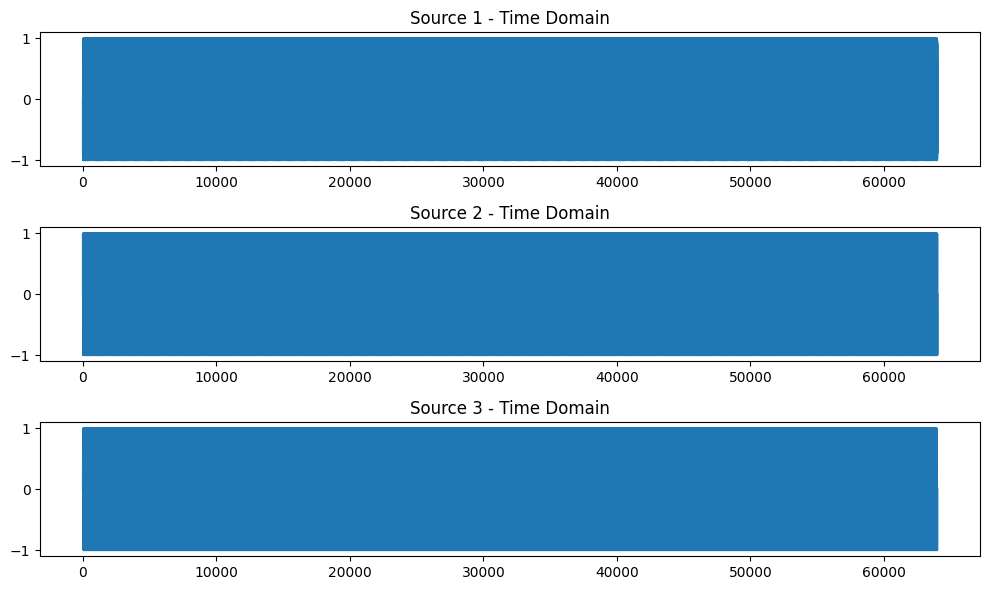

In [213]:
duration= 4
n_sources= 3
n_mixtures= 2
f_min = 10
f_max = 8000
min_spacing = (f_max-f_min)// 10 # Minimum spacing between frequencies


# Generate synthetic sources with sufficient frequency spacing
sources = generate_sources(n_sources, duration, sr, f_min=f_min, f_max=f_max, min_spacing=min_spacing)

# Plot the time-domain signals
plot_time_domain_signals(sources, sr, 'Source')

## Signal  Mixing
This section defines functions for simulating a mixing process:

1. **`delay_source`**:
   - This function simulates a delay for each source. The `rank` parameter represents the delay in samples, and the source is rolled accordingly.

2. **`simulate_mixing`**:
   - This function simulates the mixing process, where the sources are mixed according to a mixing matrix. It also applies random delays between sources.
   - The `mixing_matrix` defines the strength of the mixture between different sources, and the `delays` matrix represents the time delays for each source in the mixture.


In [214]:
def delay_source(source, rank ):
    delayed= np.roll(source, rank)
    delayed[0:rank]=np.zeros(rank)
    return delayed
# Function to simulate the mixing model

# Function to simulate the mixing model
def simulate_mixing(sources, mixing_matrix, delays, sr=16000):
    m, n = mixing_matrix.shape
    mixtures = np.zeros((m, len(sources[0])))  # Initialize mixtures matrix
    
    for i in range(m):
        for j in range(n):
            # Apply delays and attenuations
            delayed_source =  delay_source(sources[j],  int(delays[i, j] * sr)) 
            mixtures[i] += mixing_matrix[i, j] * delayed_source
    
    return mixtures


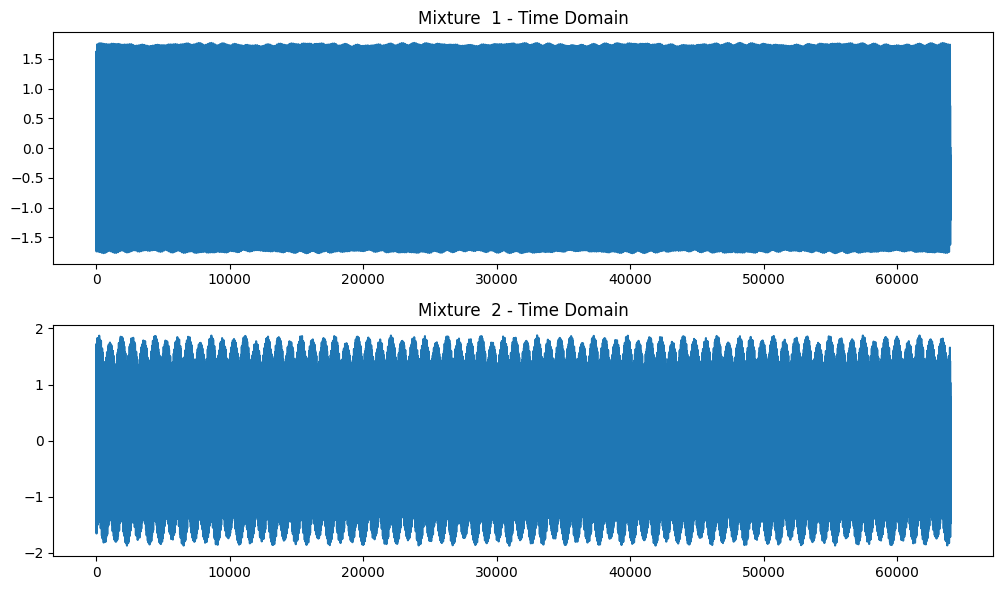

In [215]:

# Define a mixing matrix A (n_mixtures x n_sources)
mixing_matrix = np.random.rand(n_mixtures, n_sources)  # Random mixing matrix
mixing_matrix = mixing_matrix / np.linalg.norm(mixing_matrix, axis=0)  # Normalize columns


# Define delays between sources (in seconds)
delays = np.random.rand(n_mixtures, n_sources) *0 # Random delays between sources
delays[0,:]= np.zeros(n_sources)

# Simulate the mixing process
mixtures = simulate_mixing(sources, mixing_matrix, delays, sr)

plot_time_domain_signals(mixtures, sr_or_mix="Mixture ")

## Gabor Transform and Spectrogram Analysis
This section defines functions to compute the Gabor transform of signals and plot their spectrograms:

1. **`compute_gabor_transform_with_f_t`**:
   - This function computes the **Gabor transform** (short-time Fourier transform, STFT) of the input signals. The Gabor transform is used to analyze signals in both the time and frequency domains.
   - The `window_type` parameter defines the window function used for the STFT (default is Gaussian).
   - It returns the STFT matrix, along with the frequency (`f`) and time (`t`) vectors.

2. **`plot_spectrogram`**:
   - This function visualizes the spectrogram of the given STFT matrix using a logarithmic frequency axis. The spectrogram is displayed in decibels, with color representing amplitude.
   - The `title` parameter allows customization of the plot's title.

3. **Gini Index**:
   - After computing the Gabor transform of the sources and mixtures, the Gini index is calculated for each spectrogram to measure the inequality of the distribution. The lower the Gini index, the more uniform the distribution.
   - The spectrograms of the sources and mixtures are plotted, and the Gini index for each is printed.


In [216]:

window_size= 1024
hop_length=512
n_fft_0= 1024 
hop_length_0=512
# Function to compute the Gabor transform of signals
def compute_gabor_transform_with_f_t(signals, window_size=window_size, hop_length=hop_length, window_type='gaussian'):
    gabor_transforms = []
    for signal_data in signals:
        if window_type == 'gaussian':
            window = signal.windows.gaussian(window_size, std=window_size / 4)
        else:
            window = signal.windows.get_window(window_type, window_size)
        f, t, Zxx = signal.stft(signal_data, nperseg=window_size, noverlap=hop_length, window=window)
        
        gabor_transforms.append(Zxx)
    return np.array(gabor_transforms),f,t

# Function to plot the spectrogram of a signal
def plot_spectrogram(stft_matrix, sr=sr, title="Spectrogram"):
    plt.figure(figsize=(10, 6))
    
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft_matrix), ref=np.max), sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.show()



In [217]:
mixtures_stft,f,t = compute_gabor_transform_with_f_t(mixtures, window_size=window_size, hop_length=hop_length, window_type='gaussian')
sources_stft,f,t = compute_gabor_transform_with_f_t(sources, window_size=window_size, hop_length=hop_length, window_type='gaussian')

the gini index of this stft =  0.894697275614529


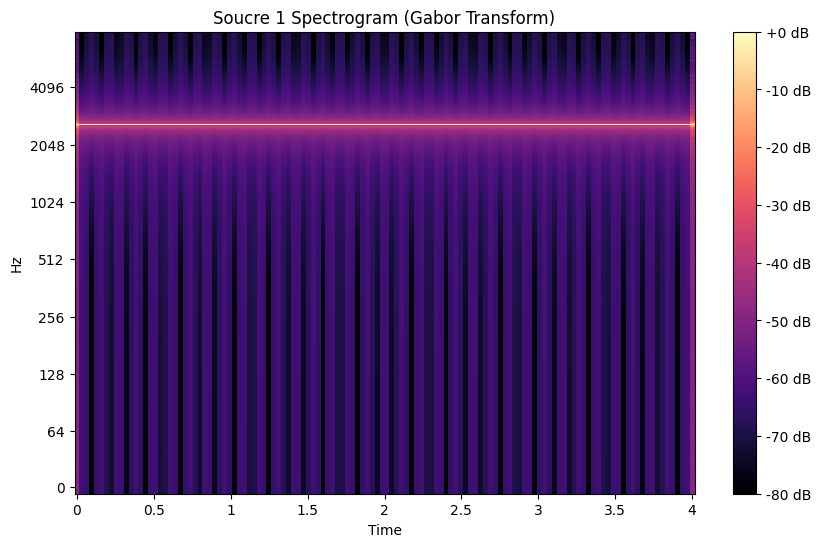

the gini index of this stft =  0.9819005685969387


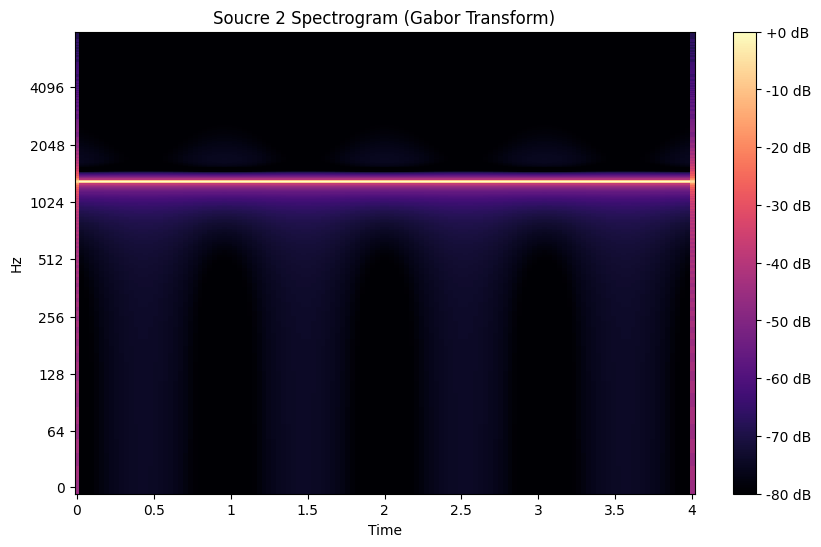

the gini index of this stft =  0.9665421259084906


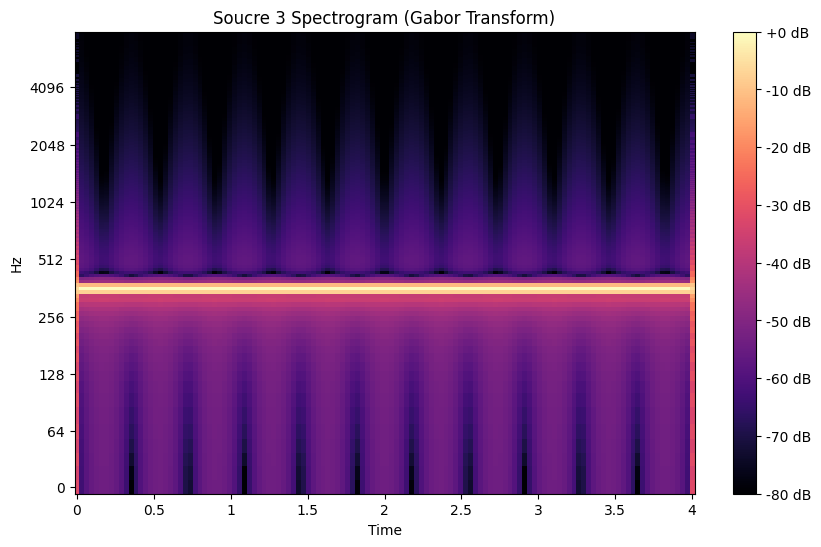

the gini index of this stft =  0.9714742257289866


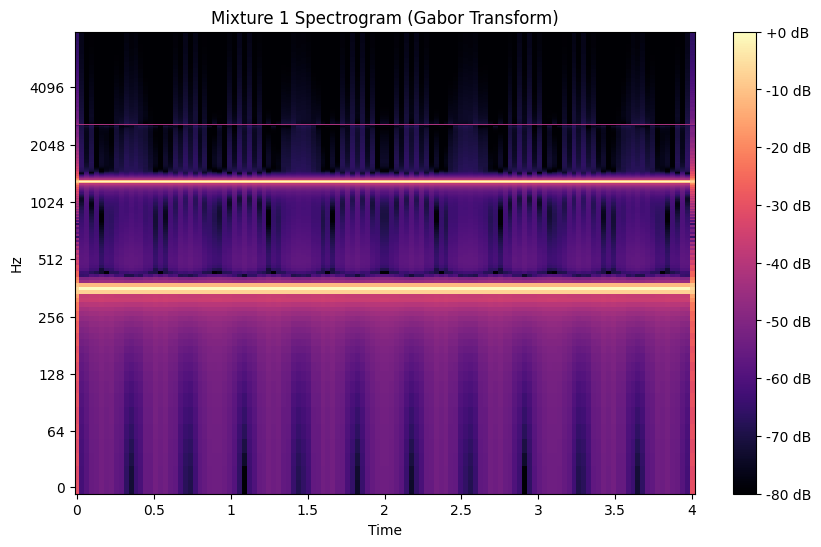

the gini index of this stft =  0.922769292057336


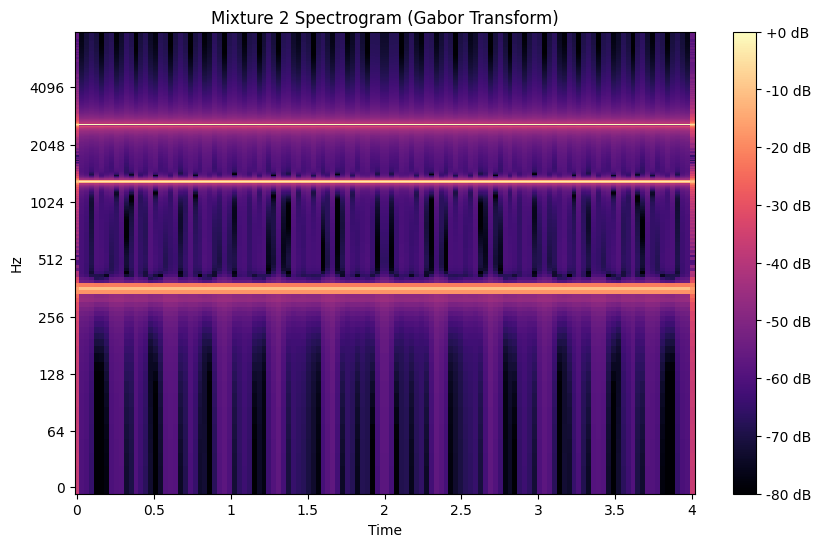

In [218]:
for i, stft in enumerate(sources_stft, 1):
    print( "the gini index of this stft = ", gini_index(stft,matrix=True))
    plot_spectrogram(stft, sr=sr, title=f"Soucre {i} Spectrogram (Gabor Transform)")
for i, stft in enumerate(mixtures_stft, 1):
    print( "the gini index of this stft = ", gini_index(stft,matrix=True))
    plot_spectrogram(stft, sr=sr, title=f"Mixture {i} Spectrogram (Gabor Transform)")


## Monte Carlo Simulation and MSE Calculation
This section runs a series of experiments to evaluate the mean squared error (MSE) for different numbers of mixtures and sources:

1. **Monte Carlo Simulation**:
   - The simulation is repeated for `N_montecarlo` trials to ensure the robustness of the results. In each trial:
     - **Synthetic Sources**: The `generate_sources` function is used to generate `n_sources` sources with sufficiently spaced frequencies.
     - **Mixing Process**: A random mixing matrix is generated, and the `simulate_mixing` function is used to simulate the mixing of sources with specified delays.
     - **System Initialization**: The `System` class is used to perform source separation, computing Gabor transforms, feature vectors, and using k-means clustering to estimate the sources.
     - The **mean squared error** (MSE) between the estimated and true attenuation matrices is computed for each trial.

2. **Results Calculation**:
   - For each combination of `n_mixtures` (number of mixtures) and `n_sources` (number of sources), the mean of the MSE values is stored in the `results` dictionary.

3. **Heatmap Visualization**:
   - The results are displayed as a heatmap, where the color intensity represents the MSE for different combinations of mixtures and sources. This visualization helps to identify which configurations lead to better separation performance (lower MSE).

The `results` dictionary stores the mean squared error for each combination of `n_mixtures` and `n_sources`, which is then used to generate the heatmap.


In [219]:
results={}
maxi_sources= 10
maxi_capteurs= 10
window_size= 1024
hop_length= 512
N_essays= 10
eps=0.05
n_sources= 4
duration= 4
sr= 16000
f_max= 8000
f_min= 10
min_spacing= ( f_max-f_min)//20
N_montecarlo=3
for n_mixtures in range(2,maxi_capteurs): 
    for n_sources in range(n_mixtures,maxi_sources ):
        print("Test: n_mixtures =", n_mixtures, "     n_sources = " , n_sources)
        experiences=[]
        for _ in range(N_montecarlo): 

        
            sources = generate_sources(n_sources, duration, sr, f_min=f_min, f_max=f_max, min_spacing=min_spacing, print_f= False)
            mixing_matrix = np.random.rand(n_mixtures, n_sources)  # Random mixing matrix
            mixing_matrix = mixing_matrix / np.linalg.norm(mixing_matrix, axis=0)  # Normalize columns
            delays = np.random.rand(n_mixtures, n_sources) *0 
            mixtures = simulate_mixing(sources, mixing_matrix, delays, sr)
            system1= System(mixtures, n_sources, window_size= window_size,hop_length=hop_length,sr= sr)
            system1.compute_gabor_transform_with_f_t()
            system1.compute_feature_vectors()
            best_mse=np.inf
            best_attentuation= None
            for _ in range(N_essays): 
                system1.compute_k_means()
                system1.estimate_aij_and_deltaij()
                system1.delays_est=system1.delays_est 
                system1.Mean_S_E_without_print(mixing_matrix,delays)
                if system1.mse < best_mse : 
                    best_attentuation = system1.attenuations_est
                if system1.mse < eps : 
                    break
            system1.attenuations_est= best_attentuation
            experiences.append(system1.Mean_S_E_without_print(mixing_matrix,delays))



        experiences= np.array(experiences)
        results[n_mixtures,n_sources ]= np.mean(experiences)
        print( "The mean suqare error of attenutaion is ", results[n_mixtures,n_sources ])
        
        

clear_output(wait=True)


Test: n_mixtures = 2      n_sources =  2


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)


The mean suqare error of attenutaion is  0.0073219022710246245
Test: n_mixtures = 2      n_sources =  3


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  se

The mean suqare error of attenutaion is  0.0711109130231158
Test: n_mixtures = 2      n_sources =  4


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  se

The mean suqare error of attenutaion is  0.24216715548598192
Test: n_mixtures = 2      n_sources =  5


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  se

The mean suqare error of attenutaion is  0.2907012164801546
Test: n_mixtures = 2      n_sources =  6


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  se

The mean suqare error of attenutaion is  0.20861301585541392
Test: n_mixtures = 2      n_sources =  7


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  se

The mean suqare error of attenutaion is  0.15255983645555468
Test: n_mixtures = 2      n_sources =  8


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  se

The mean suqare error of attenutaion is  0.3535929085142852
Test: n_mixtures = 2      n_sources =  9


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  se

The mean suqare error of attenutaion is  0.1684728466917372
Test: n_mixtures = 3      n_sources =  3


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  se

The mean suqare error of attenutaion is  0.03803520421788873
Test: n_mixtures = 3      n_sources =  4


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  se

The mean suqare error of attenutaion is  0.28353912111105567
Test: n_mixtures = 3      n_sources =  5


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  se

The mean suqare error of attenutaion is  0.3833940903366401
Test: n_mixtures = 3      n_sources =  6


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  se

The mean suqare error of attenutaion is  0.25460837573759015
Test: n_mixtures = 3      n_sources =  7


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  se

The mean suqare error of attenutaion is  0.356270062358721
Test: n_mixtures = 3      n_sources =  8


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  se

The mean suqare error of attenutaion is  0.4345934056769713
Test: n_mixtures = 3      n_sources =  9


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  se

The mean suqare error of attenutaion is  0.34992997268424636
Test: n_mixtures = 4      n_sources =  4


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  se

The mean suqare error of attenutaion is  0.22671873939716888
Test: n_mixtures = 4      n_sources =  5


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  se

The mean suqare error of attenutaion is  0.34714907250749755
Test: n_mixtures = 4      n_sources =  6


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  se

The mean suqare error of attenutaion is  0.3567465801200405
Test: n_mixtures = 4      n_sources =  7


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  se

The mean suqare error of attenutaion is  0.2703963871048753
Test: n_mixtures = 4      n_sources =  8


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  se

The mean suqare error of attenutaion is  0.34076418599177155
Test: n_mixtures = 4      n_sources =  9


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  se

The mean suqare error of attenutaion is  0.36399756242239584
Test: n_mixtures = 5      n_sources =  5


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  se

The mean suqare error of attenutaion is  0.35369288845565366
Test: n_mixtures = 5      n_sources =  6


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  se

The mean suqare error of attenutaion is  0.26935995101051025
Test: n_mixtures = 5      n_sources =  7


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  se

The mean suqare error of attenutaion is  0.2491610196666126
Test: n_mixtures = 5      n_sources =  8


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  se

The mean suqare error of attenutaion is  0.2822343474923186
Test: n_mixtures = 5      n_sources =  9


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  se

The mean suqare error of attenutaion is  0.2928682773482008
Test: n_mixtures = 6      n_sources =  6


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  se

The mean suqare error of attenutaion is  0.2398145422968416
Test: n_mixtures = 6      n_sources =  7


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  se

The mean suqare error of attenutaion is  0.3588192587032646
Test: n_mixtures = 6      n_sources =  8


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  se

The mean suqare error of attenutaion is  0.35302694591362
Test: n_mixtures = 6      n_sources =  9


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  se

The mean suqare error of attenutaion is  0.4181126850418213
Test: n_mixtures = 7      n_sources =  7


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  se

The mean suqare error of attenutaion is  0.3872351824122637
Test: n_mixtures = 7      n_sources =  8


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  se

The mean suqare error of attenutaion is  0.35557713086204984
Test: n_mixtures = 7      n_sources =  9


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  se

The mean suqare error of attenutaion is  0.32014237014525676
Test: n_mixtures = 8      n_sources =  8


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  se

The mean suqare error of attenutaion is  0.35208079095342043
Test: n_mixtures = 8      n_sources =  9


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  se

The mean suqare error of attenutaion is  0.34157695954594836
Test: n_mixtures = 9      n_sources =  9


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  se

The mean suqare error of attenutaion is  0.4107820015976638


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)


In [220]:
results

{(2, 2): 0.0073219022710246245,
 (2, 3): 0.0711109130231158,
 (2, 4): 0.24216715548598192,
 (2, 5): 0.2907012164801546,
 (2, 6): 0.20861301585541392,
 (2, 7): 0.15255983645555468,
 (2, 8): 0.3535929085142852,
 (2, 9): 0.1684728466917372,
 (3, 3): 0.03803520421788873,
 (3, 4): 0.28353912111105567,
 (3, 5): 0.3833940903366401,
 (3, 6): 0.25460837573759015,
 (3, 7): 0.356270062358721,
 (3, 8): 0.4345934056769713,
 (3, 9): 0.34992997268424636,
 (4, 4): 0.22671873939716888,
 (4, 5): 0.34714907250749755,
 (4, 6): 0.3567465801200405,
 (4, 7): 0.2703963871048753,
 (4, 8): 0.34076418599177155,
 (4, 9): 0.36399756242239584,
 (5, 5): 0.35369288845565366,
 (5, 6): 0.26935995101051025,
 (5, 7): 0.2491610196666126,
 (5, 8): 0.2822343474923186,
 (5, 9): 0.2928682773482008,
 (6, 6): 0.2398145422968416,
 (6, 7): 0.3588192587032646,
 (6, 8): 0.35302694591362,
 (6, 9): 0.4181126850418213,
 (7, 7): 0.3872351824122637,
 (7, 8): 0.35557713086204984,
 (7, 9): 0.32014237014525676,
 (8, 8): 0.35208079095342043

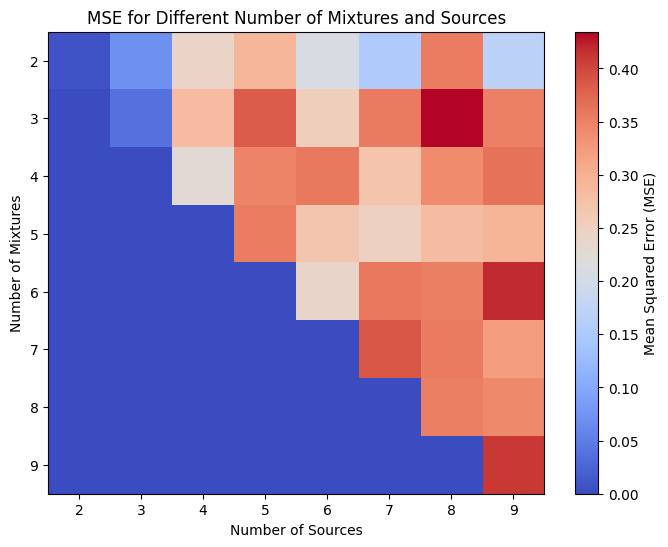

In [221]:
mse_matrix = np.zeros((maxi_capteurs-2, maxi_sources-2))

for n_mixtures in range(2, maxi_capteurs):
    for n_sources in range(n_mixtures, maxi_sources):
        mse_matrix[n_mixtures-2, n_sources-2] = results.get((n_mixtures, n_sources), np.nan)

# Plotting the results as a heatmap
plt.figure(figsize=(8, 6))
plt.imshow(mse_matrix, aspect='auto', cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='Mean Squared Error (MSE)')
plt.title('MSE for Different Number of Mixtures and Sources')
plt.xlabel('Number of Sources')
plt.ylabel('Number of Mixtures')
plt.xticks(ticks=np.arange(maxi_sources-2), labels=np.arange(2, maxi_sources))
plt.yticks(ticks=np.arange(maxi_capteurs-2), labels=np.arange(2, maxi_capteurs))
plt.show()

## Window Size Experimentation and MSE Calculation
This section performs a series of experiments to evaluate the impact of different window sizes on the mean squared error (MSE) of source separation:

1. **Experiment Setup**:
   - The experiment is conducted for different frequency values (based on powers of 2) using various window sizes: `[256, 512, 1024, 2048, 4096]`.
   - For each window size, the following steps are performed:
     - **Synthetic Sources**: The `generate_sources` function generates `n_sources` sources with frequencies spaced apart based on the `f_min`, `f_max`, and `min_spacing`.
     - **Mixing Process**: A random mixing matrix is created, and the `simulate_mixing` function is used to mix the sources with random delays.
     - **System Initialization**: The `System` class is used to perform source separation, where Gabor transforms, feature vectors, and source estimates are computed using k-means clustering and the IRLS optimization method.

2. **Mean Squared Error Calculation**:
   - The mean squared error (MSE) is calculated for the estimated attenuation matrices and compared with the true matrices. The best MSE from multiple trials (given by `N_essays`) is tracked.

3. **Results Calculation**:
   - For each window size, the mean of the MSE values is stored in the `results_window_size` dictionary.

4. **Output**:
   - The MSE for each experiment is printed, and the final results are displayed after completing the experiments for all window sizes.


In [222]:
results_window_size={}
duration= 4
sr= 48000

N_essays= 10
eps=0.05

f_max= 8000
f_min= 10
min_spacing= ( f_max-f_min)//10
n_mixtures= 2
n_sources= 3
N_monte= 100
window_sizes=[256, 512,1024, 2048, 4096 ]
for i in range(5): 
    print("################################################################################################")
    print("for frequency", 32* 2**i   )
    print("################################################################################################")
    t_window=32e-3
    window_size= window_sizes[i]
    hop_length= window_size//2
    experiments = []
    for _ in range(N_monte): 

        sources = generate_sources(n_sources, duration, sr, f_min=f_min, f_max=f_max, min_spacing=min_spacing, print_f= False)
        mixing_matrix = np.random.rand(n_mixtures, n_sources)  # Random mixing matrix
        mixing_matrix = mixing_matrix / np.linalg.norm(mixing_matrix, axis=0)  # Normalize columns
        delays = np.random.rand(n_mixtures, n_sources) *0 
        mixtures = simulate_mixing(sources, mixing_matrix, delays, sr)
        system1= System(mixtures, n_sources, window_size= window_size,hop_length=hop_length,sr= sr)
        system1.compute_gabor_transform_with_f_t()
        system1.compute_feature_vectors()
        best_mse=np.inf
        best_attentuation= None
        for _ in range(N_essays): 
            system1.compute_k_means()
            system1.estimate_aij_and_deltaij()
            system1.delays_est=system1.delays_est 
            system1.Mean_S_E_without_print(mixing_matrix,delays)
            if system1.mse < best_mse : 
                best_attentuation = system1.attenuations_est
            if system1.mse < eps : 
                break
        system1.attenuations_est= best_attentuation
        system1.Mean_S_E_without_print(mixing_matrix,delays)
        experiments.append(N_monte)
    experiments=np.array(experiments)
    results_window_size[32* 2 **i ]= np.mean(experiments)
    print( "The mean suqare error of attenutaion is ", system1.mse)
        
        
                


################################################################################################
for frequency 32
################################################################################################


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  se

The mean suqare error of attenutaion is  0.02598550036842549
################################################################################################
for frequency 64
################################################################################################


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  se

The mean suqare error of attenutaion is  0.0400305260134959
################################################################################################
for frequency 128
################################################################################################


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  se

The mean suqare error of attenutaion is  0.021234323329489584
################################################################################################
for frequency 256
################################################################################################


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  se

The mean suqare error of attenutaion is  0.0001777871615883845
################################################################################################
for frequency 512
################################################################################################


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  se

The mean suqare error of attenutaion is  0.013306218898369462


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)


In [223]:
results_window_size
for key in results_window_size.keys(): 
    print(f'For the window size {key} , the MSE of A recontruction {results_window_size[key] }')

For the window size 32 , the MSE of A recontruction 100.0
For the window size 64 , the MSE of A recontruction 100.0
For the window size 128 , the MSE of A recontruction 100.0
For the window size 256 , the MSE of A recontruction 100.0
For the window size 512 , the MSE of A recontruction 100.0


## Source Separation Methods Comparison
This section compares three source separation methods: **IRLS**, **proximal**, and **CVXPY**. The goal is to evaluate their performance in terms of the mean squared error (MSE) for estimating the attenuation matrices of mixed sources.

1. **Experiment Setup**:
   - The experiment is conducted with `n_sources = 3` sources and `n_mixtures = 2` mixtures. The duration of each signal is set to 3 seconds, and the sampling rate is `sr = 16000 Hz`.
   - A random mixing matrix and random delays are used to simulate the mixing process.
   - The following methods are tested:
     - **IRLS**: Iteratively Reweighted Least Squares optimization.
     - **proximal**: Proximal Gradient Descent optimization.
     - **CVXPY**: Convex optimization using CVXPY.

2. **Method Parameters**:
   - Each method has its own set of parameters stored in the `method_parameters` dictionary:
     - **proximal**: `q = 0.001`, `lambda_param = 0.001`, `max_iter = 300`
     - **IRLS**: `K = 50`, `q = 0.001`
     - **CVXPY**: `q = 1`, `epsilon = 1e-8`

3. **Source Separation and MSE Calculation**:
   - For each method, the system is initialized, the Gabor transform is computed, and feature vectors are extracted.
   - The best MSE is tracked across multiple trials (`N_essays`), and the optimal attenuation matrix is selected.
   - The MSE is printed, and the Gini index of the estimated sources is computed to assess the inequality of the source signals.

4. **Results**:
   - The MSE for each method is stored in the `results_method` dictionary.
   - The spectrogram of each estimated source is plotted, and the Gini index for each spectrogram is printed.

5. **Final Output**:
   - The results for each method are printed, showing the MSE of the source separation.


In [224]:
method_names=['IRLS','proximal','CVXPY']
method_parameters={}
method_parameters['proximal']= {'q': 0.001, 'lambda_param': 0.001, 'max_iter': 2*150}

method_parameters['IRLS']= {'K': 50 , 'q': 0.001}
method_parameters['CVXPY']={'q': 1, 'epsilon': 1e-8}

In [225]:
n_sources = 3
n_mixtures = 2 
duration = 3
sr=16000
f_max= 8000
f_min = 10 
min_spacing= (f_max- f_min)//10
results_method={}
sources = generate_sources(n_sources, duration, sr, f_min=f_min, f_max=f_max, min_spacing=min_spacing)

The 0-th frequency is 965 Hz
The 1-th frequency is 2455 Hz
The 2-th frequency is 7042 Hz


###################################################The method is  IRLS #########################################################################


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  se

The mean suqare error of attenutaion is  0.1557957473490463
the gini index of this stft =  0.9500679861569991


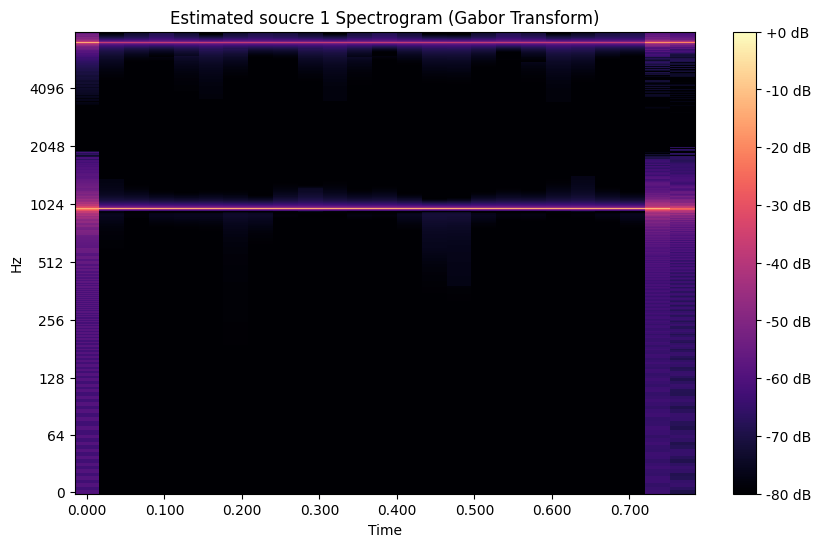

the gini index of this stft =  0.9396070726583834


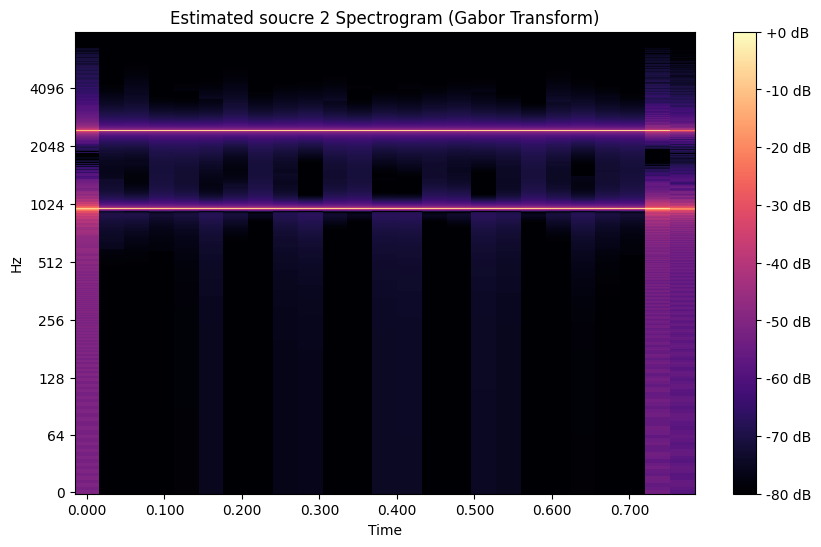

the gini index of this stft =  0.9290098978256585


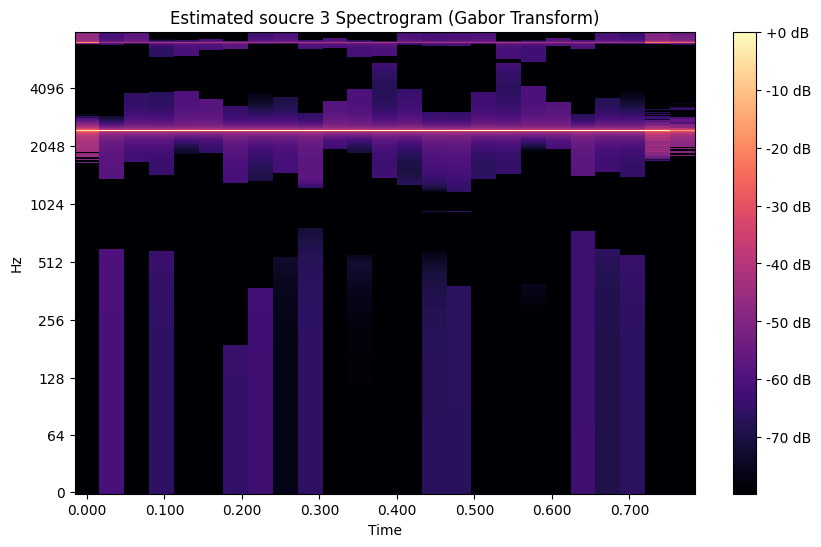

###################################################The method is  proximal #########################################################################


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  se

The mean suqare error of attenutaion is  0.17519248857277275
the gini index of this stft =  0.9966032237226173


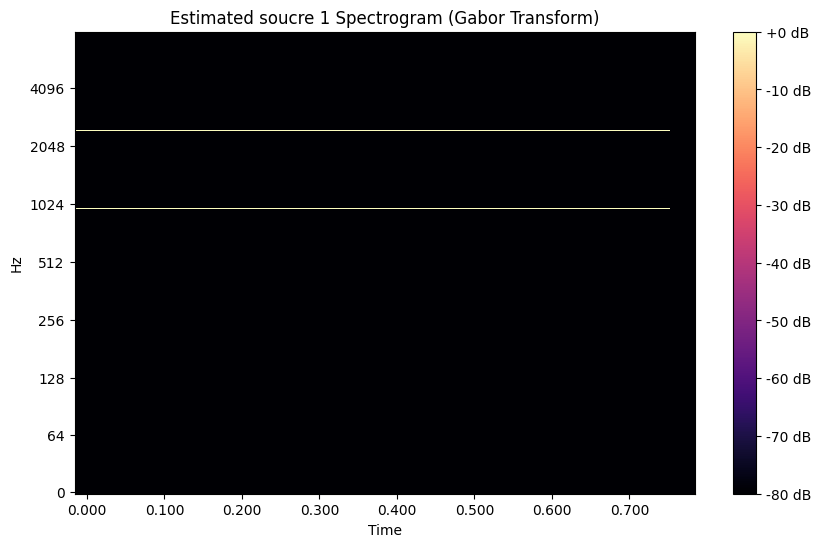

the gini index of this stft =  0.9966032236097804


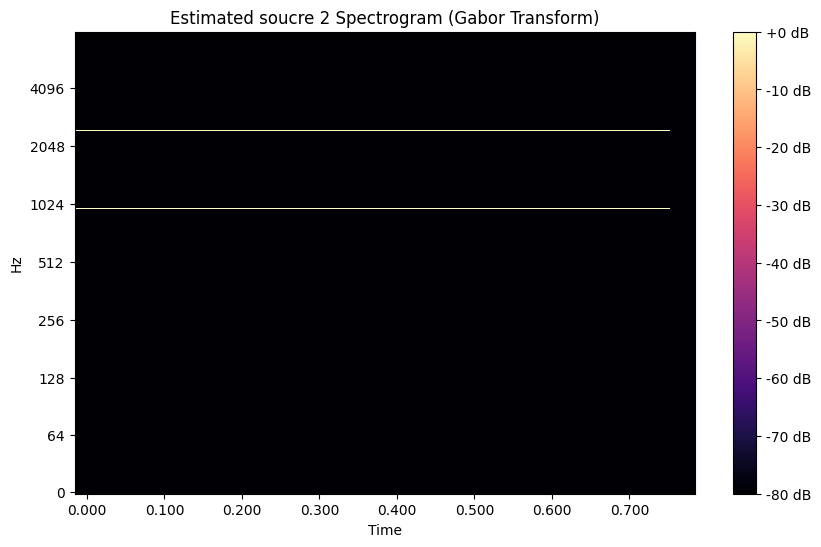

the gini index of this stft =  0.9966032236459252


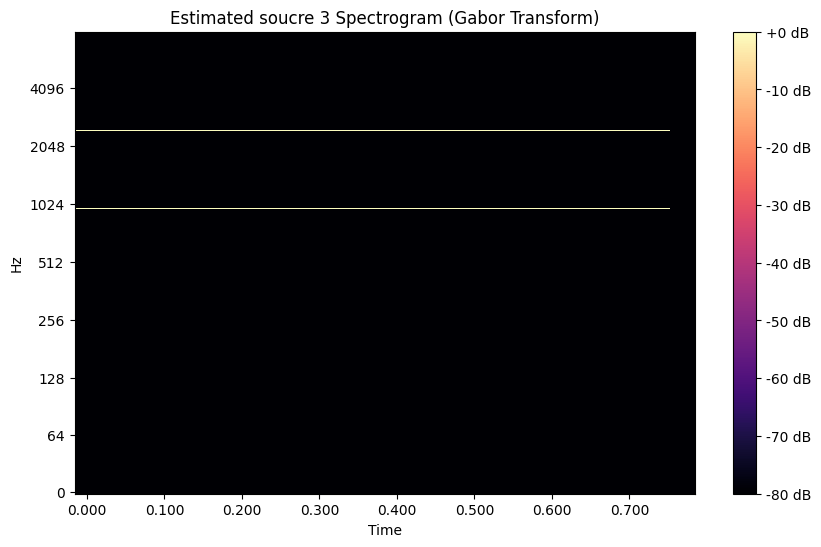

###################################################The method is  CVXPY #########################################################################


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  se

The mean suqare error of attenutaion is  0.022008346589901136
the gini index of this stft =  0.9331500660472272


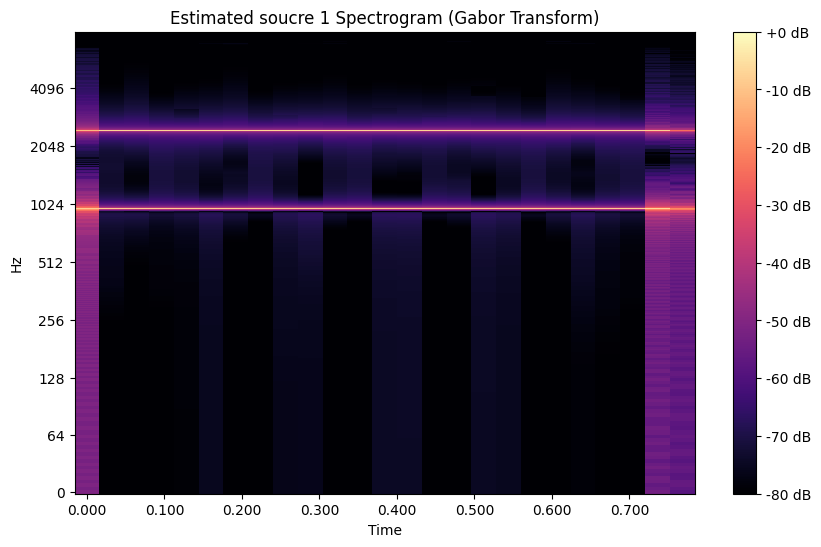

the gini index of this stft =  0.9681017380814168


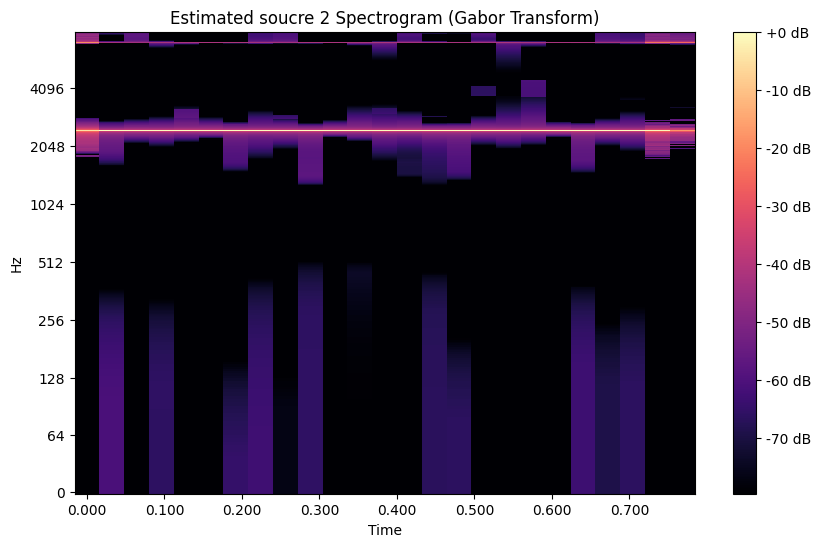

the gini index of this stft =  0.9388750278420156


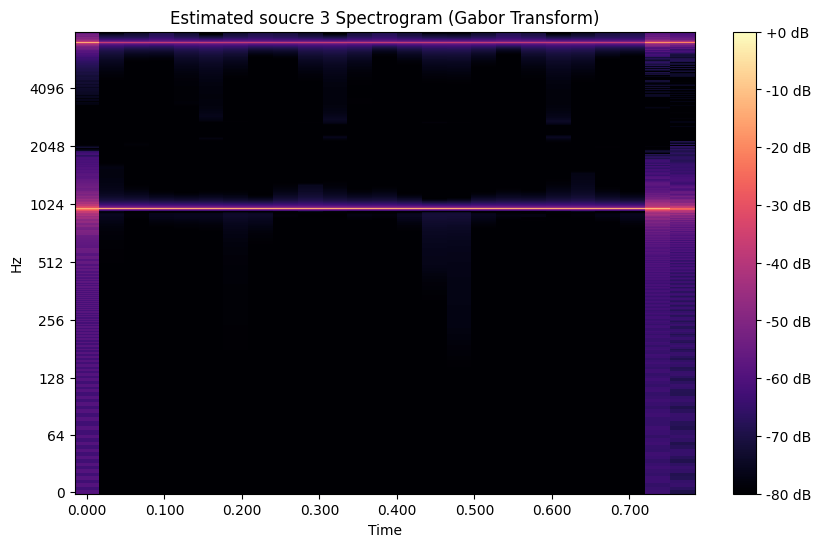

In [227]:
mixing_matrix = np.random.rand(n_mixtures, n_sources)  # Random mixing matrix
mixing_matrix = mixing_matrix / np.linalg.norm(mixing_matrix, axis=0)  # Normalize columns
delays = np.random.rand(n_mixtures, n_sources) *0 
mixtures = simulate_mixing(sources, mixing_matrix, delays, sr)
for mn in method_names: 
    print("###################################################The method is ",mn , "#########################################################################")
    system1= System(mixtures, n_sources, window_size= window_size,hop_length=hop_length,sr= sr)
    system1.compute_gabor_transform_with_f_t()
    system1.compute_feature_vectors()
    best_mse=np.inf
    best_attentuation= None
    for _ in range(N_essays): 
          system1.compute_k_means()
          system1.estimate_aij_and_deltaij()
          system1.delays_est=system1.delays_est 
          system1.Mean_S_E_without_print(mixing_matrix,delays)
          if system1.mse < best_mse : 
               best_attentuation = system1.attenuations_est
          if system1.mse < eps : 
               break
    system1.attenuations_est= best_attentuation
    system1.Mean_S_E_without_print(mixing_matrix,delays)
    results_method[mn]= system1.mse
    print( "The mean suqare error of attenutaion is ", system1.mse)
    system1.simulate_sources_stft(method_name=mn,method_params=method_parameters[mn] )
    rt=system1.get_sources_stft()
    for i, stft in enumerate(rt, 1):
        print( "the gini index of this stft = ", gini_index(stft,matrix=True))
        plot_spectrogram(stft, sr=sr, title=f"Estimated soucre {i} Spectrogram (Gabor Transform)")


In [230]:
results_method
for key in results_method.keys(): 
    print( f"The resolution with { key}, gives {results_method[key]}")

The resolution with IRLS, gives 0.1557957473490463
The resolution with proximal, gives 0.17519248857277275
The resolution with CVXPY, gives 0.022008346589901136


## Source Separation with Gabor Transform and IRLS Optimization
This section demonstrates the process of source separation using the **IRLS** optimization method. The steps involved are as follows:

1. **Source Signal Generation**:
   - Synthetic sources are generated using the `generate_sources` function, where `n_sources = 3` and each source has frequencies spaced apart based on `f_min` and `f_max`. The signals are sampled at `sr = 48000` Hz.
   - The time-domain representation of the generated sources is visualized using the `plot_time_domain_signals` function.

2. **Gabor Transform (STFT)**:
   - The **Gabor Transform** (STFT) is computed for each source using the `compute_gabor_transform_with_f_t` function. This provides a time-frequency representation of the signals.
   - The spectrogram of each source is plotted, and the **Gini index** of the STFT is calculated to evaluate the inequality in the signal.

3. **Mixing Process**:
   - A random mixing matrix is generated, and the sources are mixed using the `simulate_mixing` function, with delays applied between the mixtures.
   - The time-domain representation of the mixtures is visualized.

4. **Mixture Spectrogram**:
   - The Gabor Transform is applied to the mixed signals to generate their spectrograms.
   - The Gini index for each mixture's STFT is computed and displayed, helping assess the mixture's inequality.

5. **Source Separation**:
   - The `System` class is used to perform source separation. The Gabor transform of the mixtures is computed, and feature vectors are extracted.
   - The system employs k-means clustering to estimate the sources, and the best attenuation matrix is selected based on the **Mean Squared Error (MSE)**.

6. **Optimization and Estimation**:
   - The IRLS method is used to estimate the sources, and the **Mean Squared Error (MSE)** is computed to evaluate the accuracy of the separation.
   - The estimated sources are visualized, and their Gini index is calculated and plotted.

7. **Visualization**:
   - The estimated sources' spectrograms are plotted to visually inspect the separation quality.

This experiment uses **IRLS** for optimization, and the results are evaluated based on MSE, Gini index, and visual inspection of the spectrograms of the estimated sources.


The 0-th frequency is 6323 Hz
The 1-th frequency is 4730 Hz
The 2-th frequency is 2891 Hz


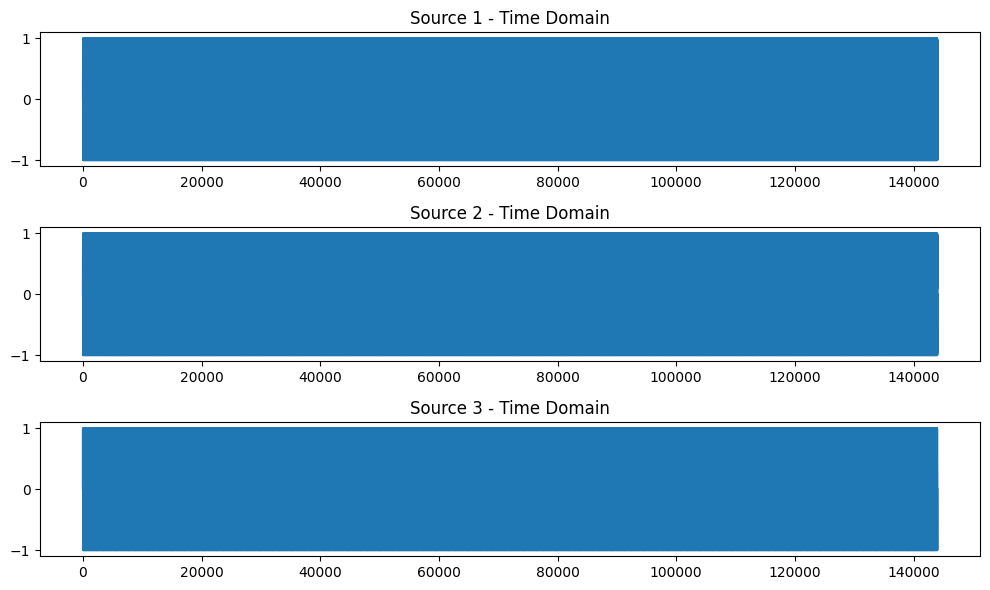

the gini index of this stft =  0.9477967002989023


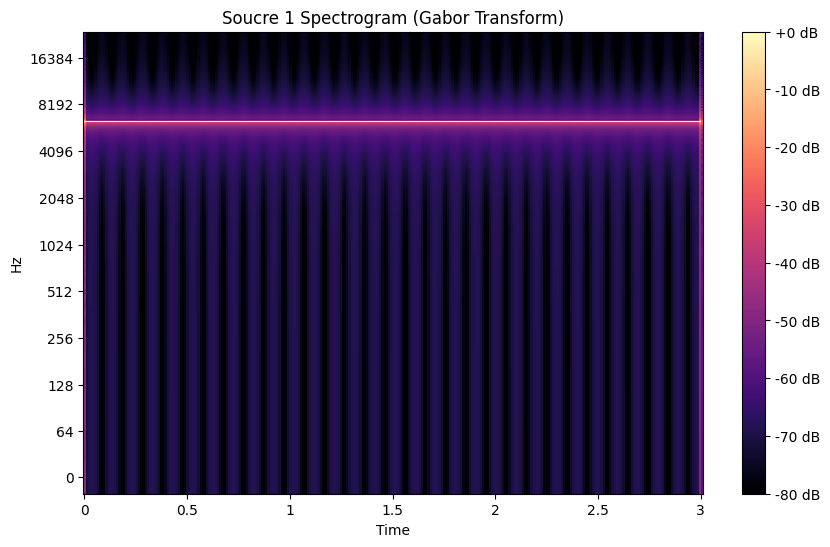

the gini index of this stft =  0.9563610417823784


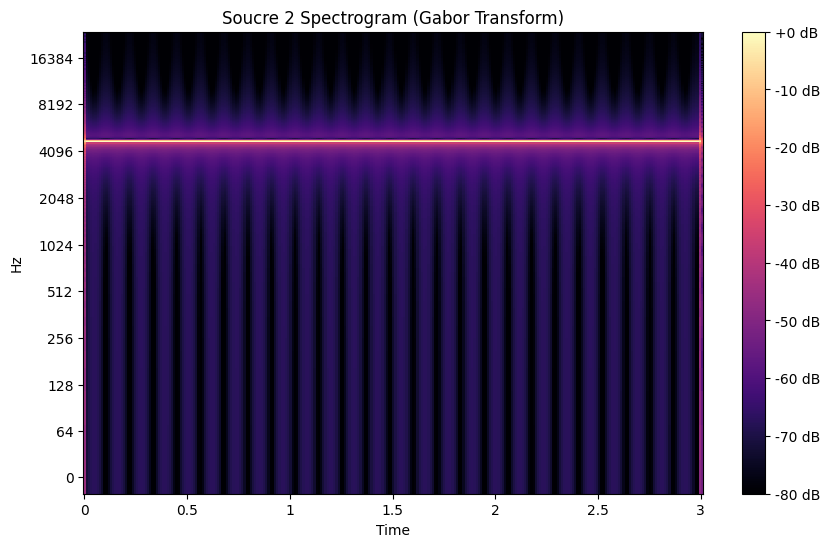

the gini index of this stft =  0.9045390054998853


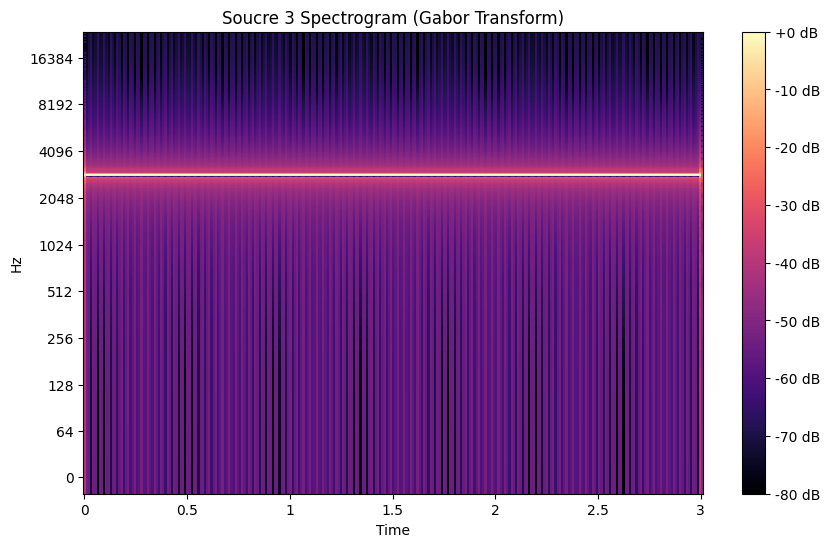

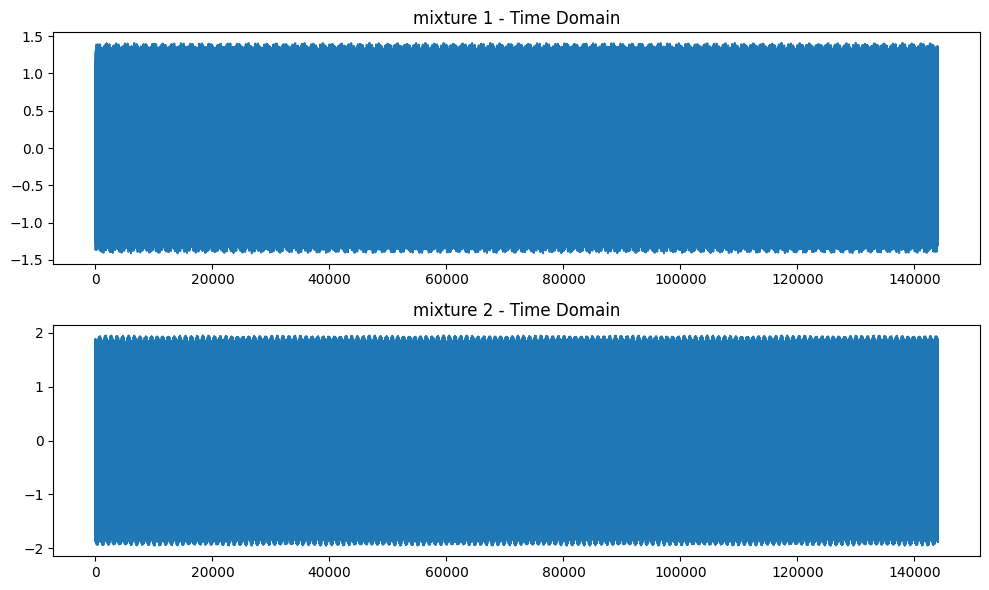

the gini index of this stft =  0.9191517216552574


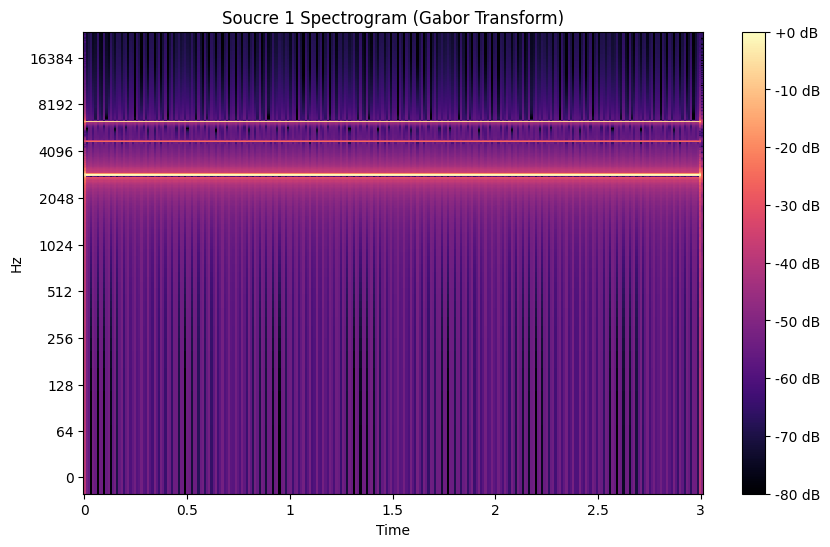

the gini index of this stft =  0.9598853739750437


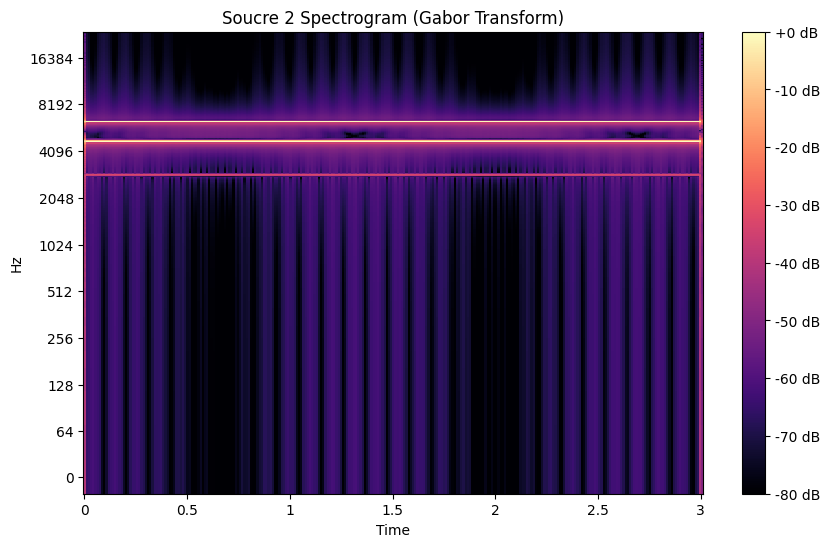

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  se

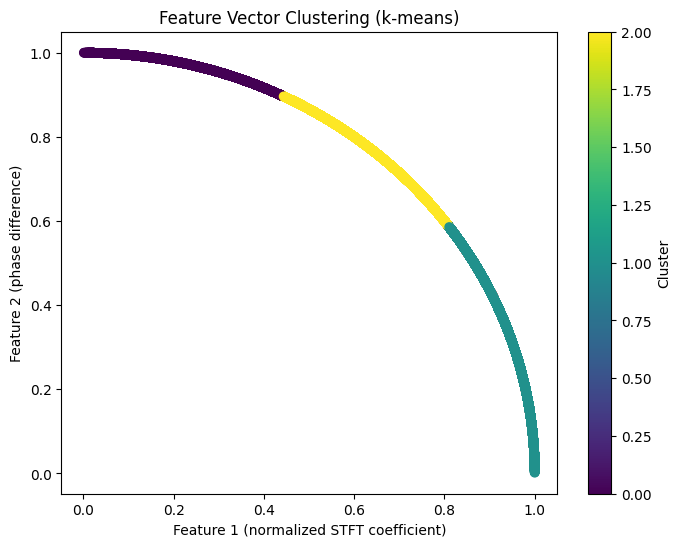

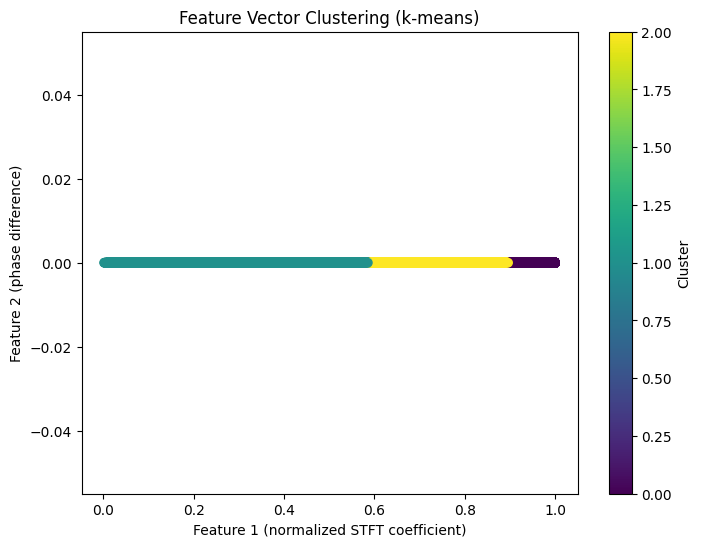

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:124: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)


The mean suqare error of delays is  nan
The True matrix is 
 [[0. 0.]
 [0. 0.]
 [0. 0.]]
The estiamted matrix is 
 [[0. 0.]
 [0. 0.]
 [0. 0.]]
The mean suqare error of attenutaion is  0.6534192524883127
The True matrix is 
 [[0.36172571 0.93228457]
 [0.04971544 0.99876342]
 [0.99972287 0.02354088]]
The estiamted matrix is 
 [[0.25008584 0.96069814]
 [0.92715627 0.33301816]
 [0.60451377 0.78359192]]
The mean suqare error of attenutaion is  0.6534192524883127
the gini index of this stft =  0.9303435139299799


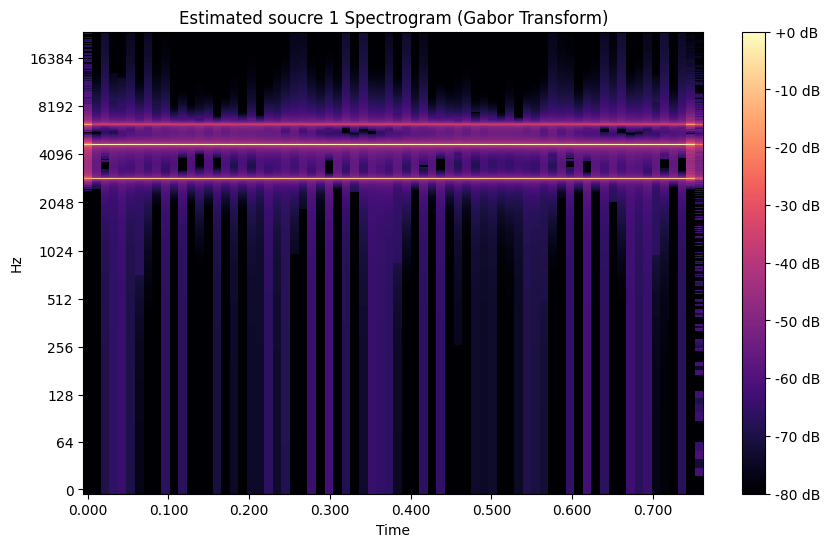

the gini index of this stft =  0.9476028069174722


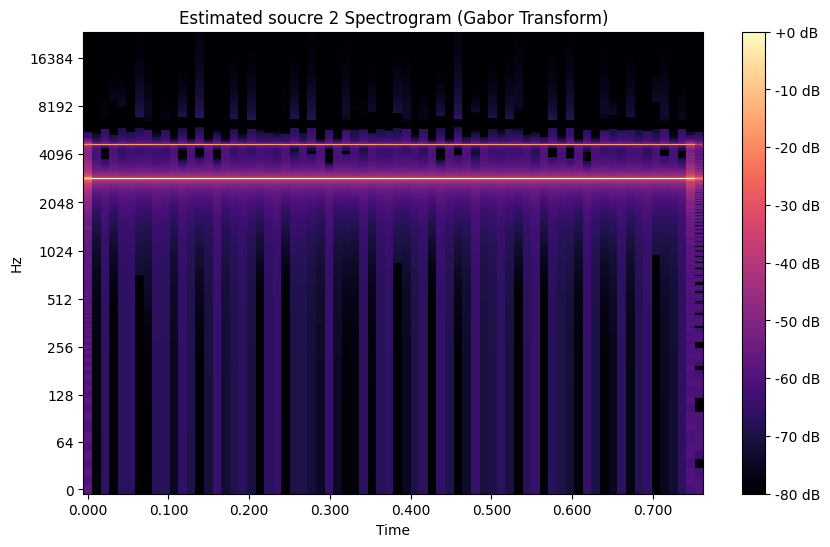

the gini index of this stft =  0.9535093315963659


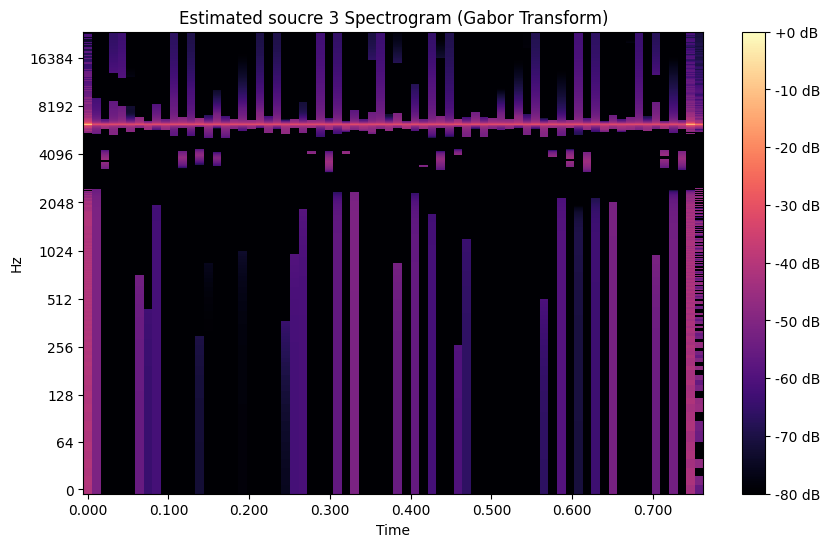

In [231]:
duration= 4
sr= 48000
N_essays= 10
eps=0.05
n_sources = 3
n_mixtures = 2 
duration = 3
sr=48000
f_max= 8000
f_min = 10 
min_spacing= (f_max- f_min)//10
method= 'IRLS'
sources = generate_sources(n_sources, duration, sr, f_min=f_min, f_max=f_max, min_spacing=min_spacing)
plot_time_domain_signals(sources, sr, 'Source')
sources_stft,f,t = compute_gabor_transform_with_f_t(sources, window_size=n_fft_0, hop_length=hop_length_0, window_type='gaussian')
for i, stft in enumerate(sources_stft, 1):
    print( "the gini index of this stft = ", gini_index(stft,matrix=True))
    plot_spectrogram(stft, sr=sr, title=f"Soucre {i} Spectrogram (Gabor Transform)")

mixing_matrix = np.random.rand(n_mixtures, n_sources)  # Random mixing matrix
mixing_matrix = mixing_matrix / np.linalg.norm(mixing_matrix, axis=0)  # Normalize columns
delays = np.random.rand(n_mixtures, n_sources) *0 
mixtures = simulate_mixing(sources, mixing_matrix, delays, sr)
plot_time_domain_signals(mixtures, sr, 'mixture')

mixtures_stft,f,t = compute_gabor_transform_with_f_t(mixtures, window_size=n_fft_0, hop_length=hop_length_0, window_type='gaussian')
for i, stft in enumerate(mixtures_stft, 1):
    print( "the gini index of this stft = ", gini_index(stft,matrix=True))
    plot_spectrogram(stft, sr=sr, title=f"Soucre {i} Spectrogram (Gabor Transform)")

system1= System(mixtures, n_sources, window_size= window_size,hop_length=hop_length,sr= sr)
system1.compute_gabor_transform_with_f_t()
system1.compute_feature_vectors()
best_mse=np.inf
best_attentuation= None
for _ in range(N_essays): 
    system1.compute_k_means()
    system1.estimate_aij_and_deltaij()
    system1.delays_est=system1.delays_est 
    system1.Mean_S_E_without_print(mixing_matrix,delays)
    if system1.mse < best_mse : 
        best_attentuation = system1.attenuations_est
    if system1.mse < eps : 
       break
system1.plot_clusters(indx1=0, indx2=1)
system1.plot_clusters(indx1=1, indx2=2)
system1.attenuations_est= best_attentuation
system1.Mean_S_E(mixing_matrix,delays)
results_method[mn]= system1.mse
print( "The mean suqare error of attenutaion is ", system1.mse)
system1.simulate_sources_stft(method_name=method,method_params=method_parameters[method] )
rt=system1.get_sources_stft()
for i, stft in enumerate(rt, 1):
     print( "the gini index of this stft = ", gini_index(stft,matrix=True))
     plot_spectrogram(stft, sr=sr, title=f"Estimated soucre {i} Spectrogram (Gabor Transform)")




## Source Separation from Audio Files with Gabor Transform and IRLS Optimization
In this section, we perform source separation on audio files using the **IRLS** optimization method. The steps involved are as follows:

1. **Loading Audio Files**:
   - The `read_sources` function loads the first 3 seconds of audio from each file in the `audio_paths` list. The audio is sampled at `sr = 48000` Hz.

2. **Time-Domain Visualization**:
   - The time-domain representation of the source signals is visualized using the `plot_time_domain_signals` function to inspect the original audio signals.

3. **Gabor Transform (STFT)**:
   - The **Gabor Transform** (STFT) is computed for each source using the `compute_gabor_transform_with_f_t` function. This transforms the sources into a time-frequency representation.
   - The spectrogram of each source is plotted, and the **Gini index** is computed to evaluate the inequality in the signal distribution.

4. **Mixture Simulation**:
   - A random mixing matrix and delays are used to simulate the mixing of the sources. The `simulate_mixing` function is applied to create the mixtures.
   - The time-domain representation of the mixtures is plotted.

5. **Mixture Spectrogram**:
   - The Gabor Transform is applied to the mixtures to obtain their time-frequency representation. The spectrograms of the mixtures are plotted, and the Gini index is calculated.

6. **Source Separation**:
   - The `System` class is used to perform source separation on the mixtures. The Gabor transform of the mixtures is computed, and feature vectors are extracted.
   - The system employs **k-means clustering** to estimate the sources. The best attenuation matrix is selected based on the **Mean Squared Error (MSE)**.

7. **Optimization and Estimation**:
   - The **IRLS** method is used to estimate the sources. The **MSE** is computed and compared with the true attenuation matrices. The separation quality is assessed using the MSE.

8. **Visualization**:
   - The estimated sources' spectrograms are plotted to visually inspect the separation. The **Gini index** is calculated for each estimated source to assess the inequality in the separation.

This experiment uses **IRLS** for optimization, and the results are evaluated based on MSE, Gini index, and visual inspection of the spectrograms of the estimated sources.


In [232]:
sr=48000
audio_paths=['sample-000000.mp3','sample-000002.mp3','sample-000013.mp3']
def read_sources(audio_paths=audio_paths, sr=sr):
    sources= []
    for audio_path in audio_paths:
        audio, sr = librosa.load(audio_path, sr=sr)  # sr is the sample rate (set to 16kHz)
        first_3_seconds = audio[:sr*3] 
        sources.append(first_3_seconds)
        
    sources=np.array(sources)
    return sources
sources= read_sources(audio_paths)


In [233]:
method_names=['IRLS','proximal','CVXPY']
method_parameters={}
method_parameters['proximal']= {'q': 0.001, 'lambda_param': 0.001, 'max_iter': 2*150}

method_parameters['IRLS']= {'K': 50 , 'q': 0.5}
method_parameters['CVXPY']={'q': 1, 'epsilon': 1e-8}

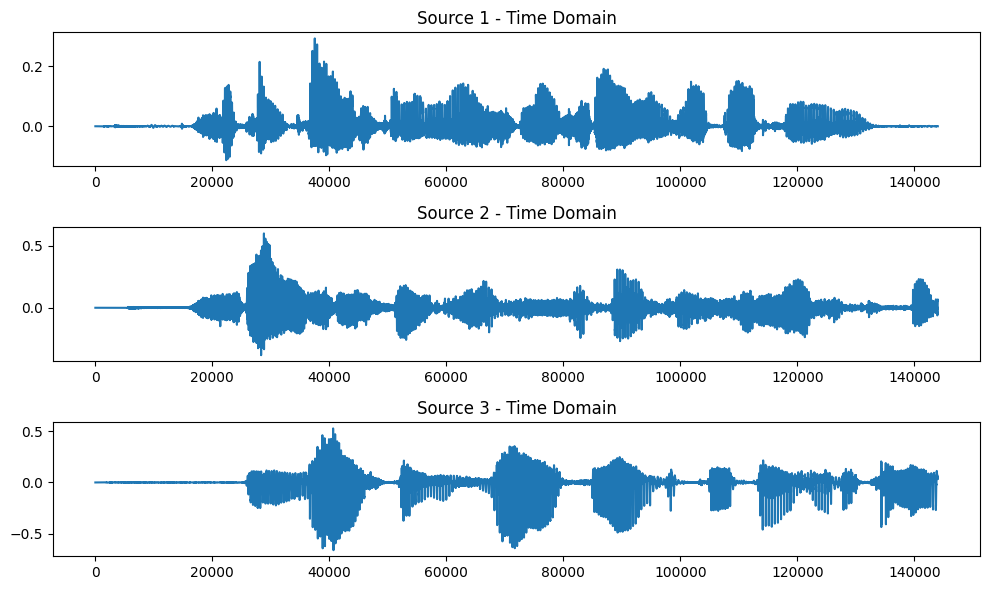

the gini index of this stft =  0.926782240661137


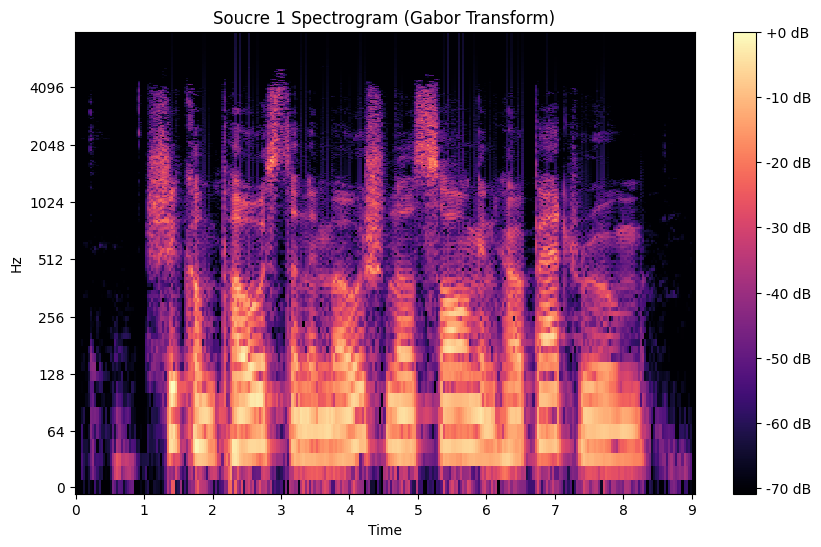

the gini index of this stft =  0.9105983311854304


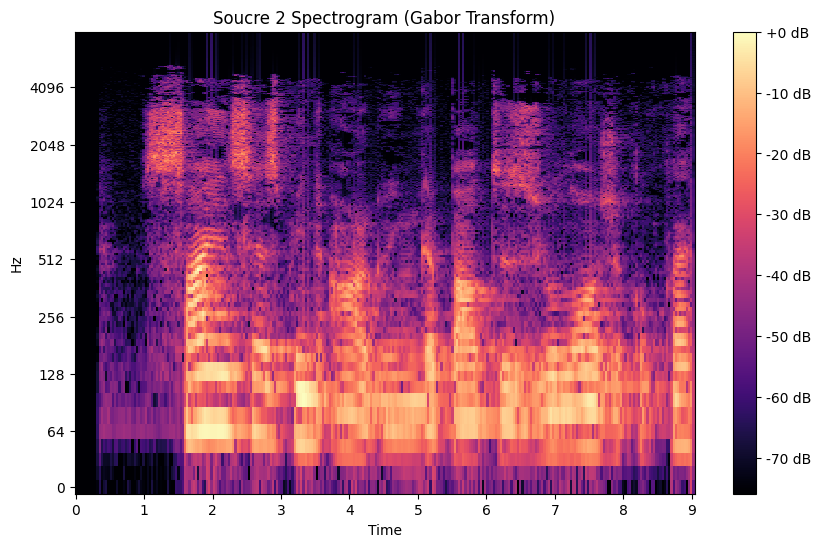

the gini index of this stft =  0.9595825492914303


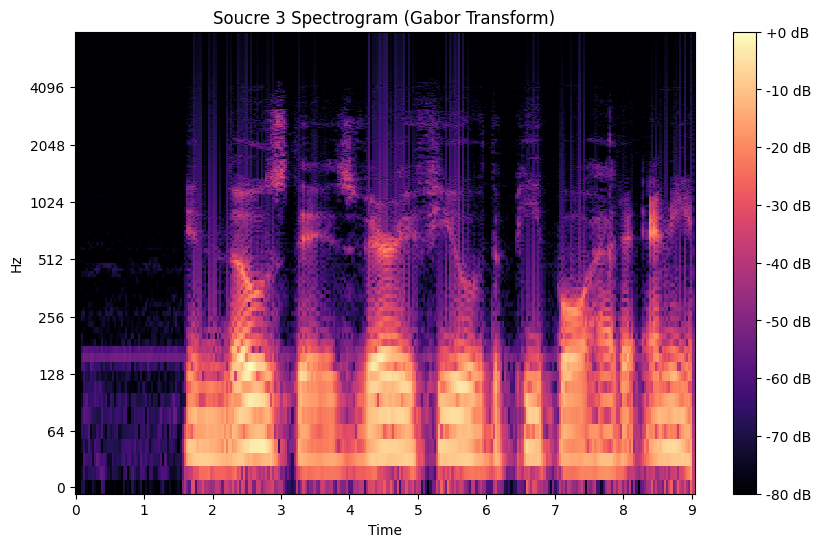

In [234]:
N_essays= 150
n_sources = 3
n_mixtures = 2 
duration = 3
sr=16000
taux_window= 128e-3
window_size= 1024
hop_length=512
method= 'IRLS'
sources= read_sources(audio_paths)
plot_time_domain_signals(sources, sr, 'Source')
sources_stft,f,t = compute_gabor_transform_with_f_t(sources, window_size=window_size, hop_length=hop_length, window_type='gaussian')
for i, stft in enumerate(sources_stft, 1):
    print( "the gini index of this stft = ", gini_index(stft,matrix=True))
    plot_spectrogram(stft, sr=sr, title=f"Soucre {i} Spectrogram (Gabor Transform)")

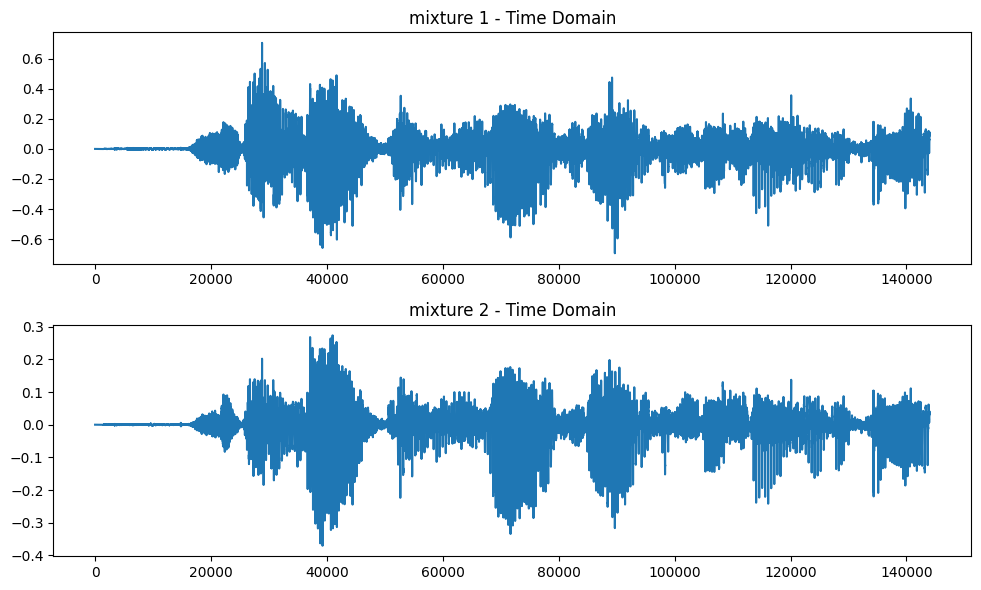

the gini index of this stft =  0.9164690662211294


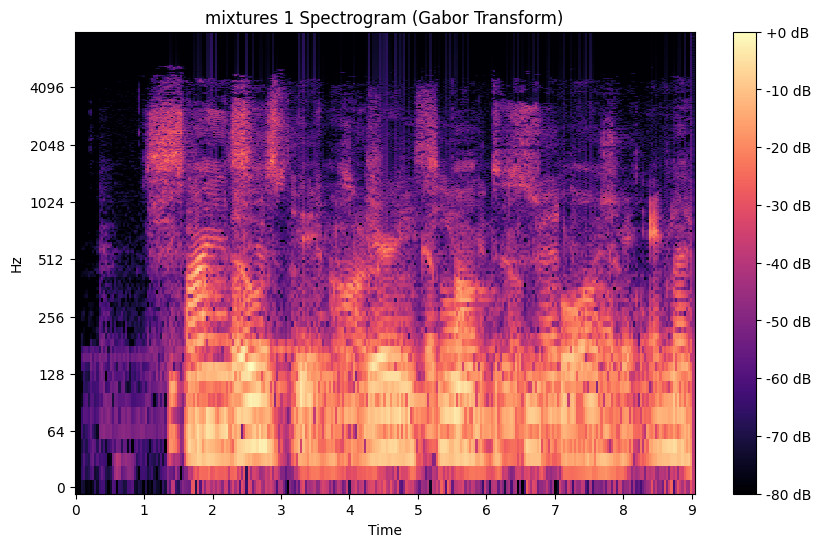

the gini index of this stft =  0.9262354596459851


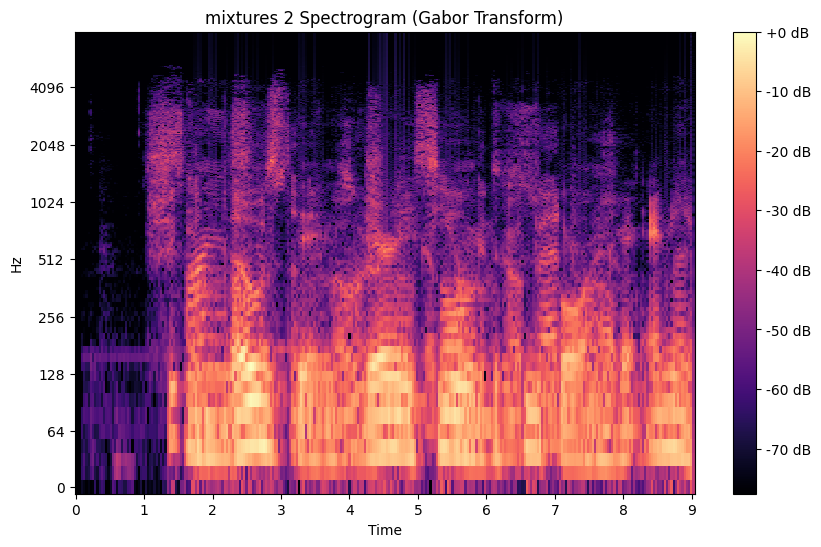

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:108: RuntimeWarning: invalid value encountered in scalar divide
  se

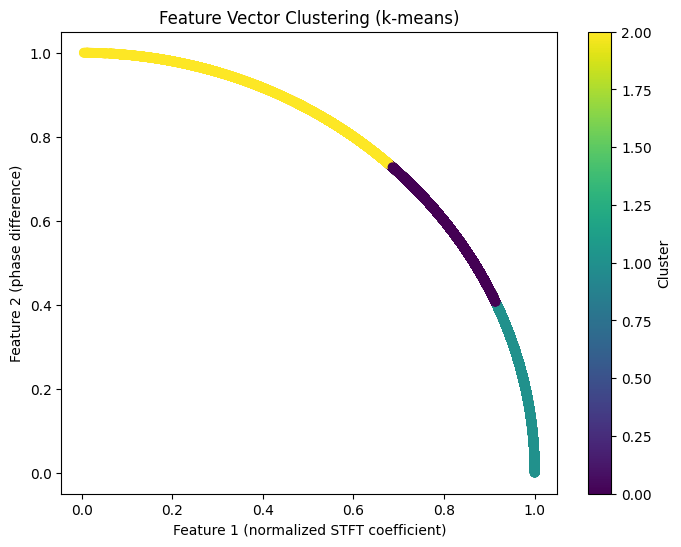

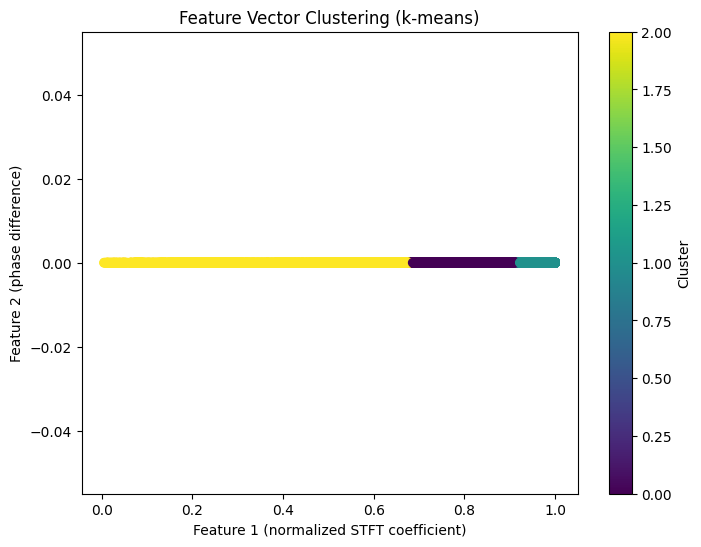

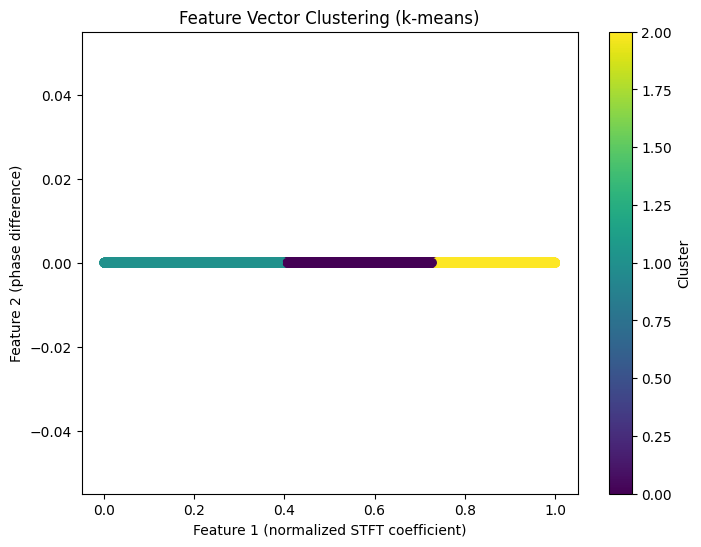

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\2250480443.py:124: RuntimeWarning: invalid value encountered in scalar divide
  self.mse = np.mean((self.delays_est - Matrix_delays)**2) /  np.mean( Matrix_delays**2)


The mean suqare error of delays is  nan
The True matrix is 
 [[0. 0.]
 [0. 0.]
 [0. 0.]]
The estiamted matrix is 
 [[0. 0.]
 [0. 0.]
 [0. 0.]]
The mean suqare error of attenutaion is  0.1005279184655763
The True matrix is 
 [[0.78417589 0.62053862]
 [0.97858366 0.20584949]
 [0.8619571  0.50698122]]
The estiamted matrix is 
 [[0.83832776 0.53732496]
 [0.96355286 0.25218052]
 [0.46114006 0.86572908]]
The mean suqare error of attenutaion is  0.1005279184655763
the gini index of this stft =  0.9705950966694485


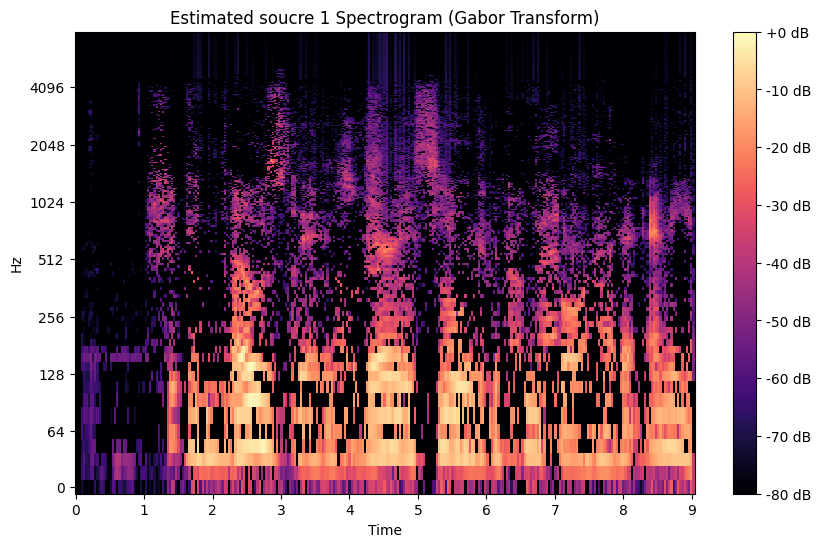

the gini index of this stft =  0.9233241283323526


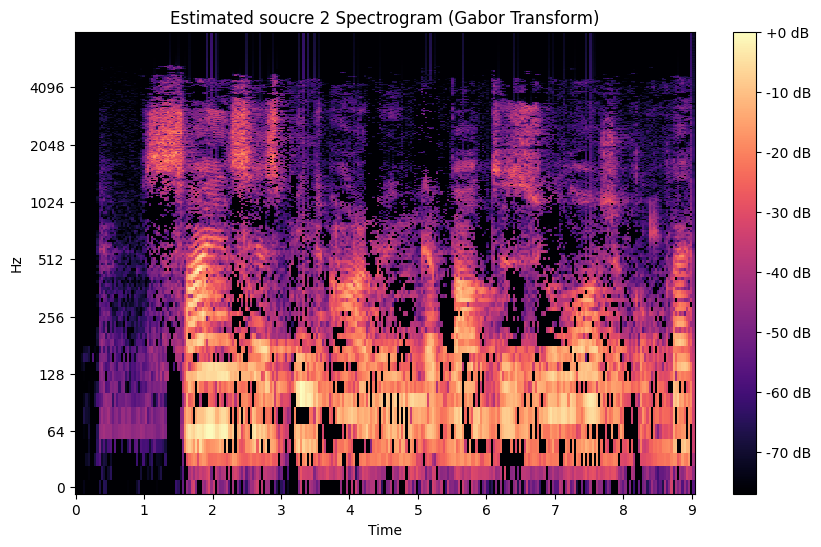

the gini index of this stft =  0.9285036472192459


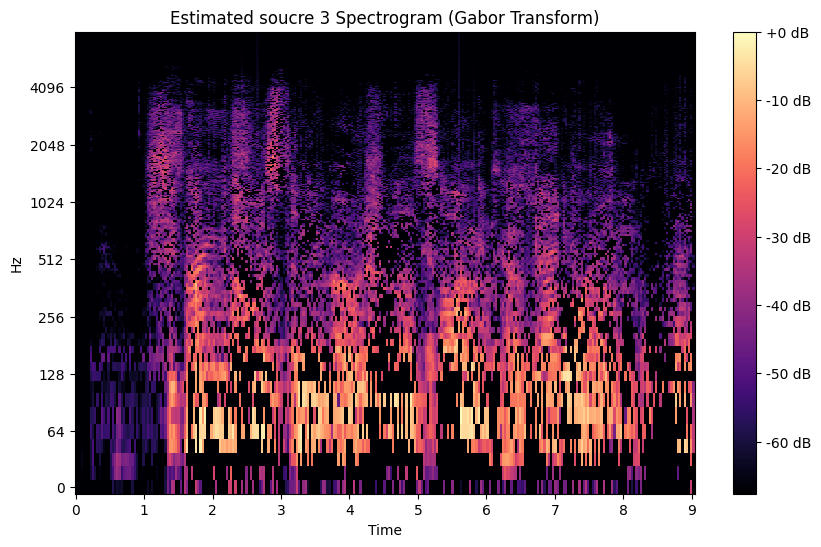

In [235]:


mixing_matrix = np.random.rand(n_mixtures, n_sources)  # Random mixing matrix
mixing_matrix = mixing_matrix / np.linalg.norm(mixing_matrix, axis=0)  # Normalize columns
delays = np.random.rand(n_mixtures, n_sources) *0 
mixtures = simulate_mixing(sources, mixing_matrix, delays, sr)
plot_time_domain_signals(mixtures, sr, 'mixture')

mixtures_stft,f,t = compute_gabor_transform_with_f_t(mixtures, window_size=n_fft_0, hop_length=hop_length_0, window_type='gaussian')
for i, stft in enumerate(mixtures_stft, 1):
    print( "the gini index of this stft = ", gini_index(stft,matrix=True))
    plot_spectrogram(stft, sr=sr, title=f"mixtures {i} Spectrogram (Gabor Transform)")

system1= System(mixtures, n_sources, window_size= window_size,hop_length=hop_length,sr= sr)
system1.compute_gabor_transform_with_f_t()
system1.compute_feature_vectors()
best_mse=np.inf
best_attentuation= None
for _ in range(N_essays): 
    system1.compute_k_means()
    system1.estimate_aij_and_deltaij()
    system1.delays_est=system1.delays_est 
    system1.Mean_S_E_without_print(mixing_matrix,delays)
    if system1.mse < best_mse : 
        best_attentuation = system1.attenuations_est
    if system1.mse < eps : 
       break
system1.plot_clusters(indx1=0, indx2=1)
system1.plot_clusters(indx1=0, indx2=2)
system1.plot_clusters(indx1=1, indx2=2)
system1.attenuations_est= best_attentuation
system1.Mean_S_E(mixing_matrix,delays)
results_method[mn]= system1.mse
print( "The mean suqare error of attenutaion is ", system1.mse)
system1.simulate_sources_stft(method_name=method,method_params=method_parameters[method] )
rt=system1.get_sources_stft()
for i, stft in enumerate(rt, 1):
     print( "the gini index of this stft = ", gini_index(stft,matrix=True))
     plot_spectrogram(stft, sr=sr, title=f"Estimated soucre {i} Spectrogram (Gabor Transform)")




## Signal Reconstruction from Gabor Transforms
In this section, we perform the reconstruction of the source signals from their **Gabor Transform (STFT)** representations. The steps involved are as follows:

1. **Reconstructing the Signals**:
   - The function `reconstruct_signal_from_gabor` takes the Gabor transforms of the sources and applies the **Inverse Short-Time Fourier Transform (ISTFT)** to reconstruct the original time-domain signals.
   - The ISTFT is applied using a Gaussian window or other specified window types, with a specified window size and hop length.

2. **Audio Playback**:
   - After reconstructing the signals, the `Audio` function from the `IPython.display` module is used to play back the reconstructed signal of a specific source (`reconstructed_signals[2]` in this case).
   - The `rate` is set to `sr`, the sampling rate of the signal.

This process demonstrates how to take the time-frequency representations (Gabor transforms) of the signals and reconstruct the original signals, allowing for audio playback to assess the quality of


In [244]:
from IPython.display import Audio
import scipy.signal as signal
def reconstruct_signal_from_gabor(gabor_transforms, window_size=1024, hop_length=512, window_type='gaussian'):
    reconstructed_signals = []
    
    for Zxx in gabor_transforms:
        if window_type == 'gaussian':
            window = signal.windows.gaussian(window_size, std=window_size / 4)
        else:
            window = signal.windows.get_window(window_type, window_size)

        # Inverse STFT to reconstruct the signal
        _, reconstructed_signal = signal.istft(Zxx, nperseg=window_size, noverlap=hop_length, window=window)
        reconstructed_signals.append(reconstructed_signal)
    
    return np.array(reconstructed_signals)


reconstructed_signals= reconstruct_signal_from_gabor(rt, window_size=1024, hop_length=512, window_type='gaussian')

Audio(reconstructed_signals[2], rate=sr*3)


In [240]:

# Play all reconstructed signals
for i, signal in enumerate(mixtures):
    print(f"Playing mixed signal {i+1}")
    display(Audio(signal, rate=sr*3))  # Display the audio player for each signal


Playing mixed signal 1


Playing mixed signal 2


In [239]:
# Play all reconstructed signals
for i, signal in enumerate(reconstructed_signals):
    print(f"Playing reconstructed signal {i+1}")
    display(Audio(signal, rate=sr*3))  # Display the audio player for each signal


Playing reconstructed signal 1


Playing reconstructed signal 2


Playing reconstructed signal 3
